In [1]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit.opflow import TwoQubitReduction
from qiskit.utils import QuantumInstance
from qiskit import IBMQ, BasicAer, Aer
from qiskit.algorithms.optimizers import COBYLA
from concurrent.futures import ThreadPoolExecutor
from qiskit_nature.algorithms import (GroundStateEigensolver,
                                      NumPyMinimumEigensolverFactory)
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.algorithms import VQE

def exact_solver(problem, converter):
    print(problem)
    print(converter)
    #print("I AM HERE11")
    solver = NumPyMinimumEigensolverFactory()
    #print("I AM HERE12")
    calc = GroundStateEigensolver(converter, solver)
    #print("I AM HERE13")
    #result = calc.solve(problem)
    #print("I AM HERE14")
    return 0

def get_qubit_op(coordinates):
    
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
            ["H", [coordinates[0],coordinates[1],0]],
            ["H", [coordinates[2],coordinates[3],0]],
            ["H", [coordinates[4],coordinates[5],0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=1,
    )

    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)
    
    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True)])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles

    mapper = ParityMapper()  # Set Mapper
    #hamiltonian = electronic_energy.second_q_ops()["ElectronicEnergy"]
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

def calc_ground_state(op,num_part,num_orb,problem,converter,simulator='qasm', shots=1028):
    
    
    if simulator == 'exact':
        backend = Aer.get_backend('qasm_simulator')
        #backend.set_options(max_job_size=1,executor=euler_client)
        quantum_instance = QuantumInstance(backend,shots=shots)
        optimizer = COBYLA(maxiter=400)
    elif simulator == 'qasm':
        backend = BasicAer.get_backend("statevector_simulator")
        quantum_instance = QuantumInstance(backend)
        optimizer = COBYLA(maxiter=400)
    else:
        print('Error: simulator should be qasm or exact!')
     
    #result = exact_solver(problem,converter)
    
    #print(num_orb)
    #print(num_part)
    num_orb = 4
    init_state = HartreeFock(num_orb, num_part, converter)
    
    #print(init_state)
    #print(op)
     
    var_form = UCCSD(converter,
                        num_part,
                        num_orb,
                        initial_state=init_state)

    vqe = VQE(var_form, optimizer, quantum_instance=quantum_instance) 

    vqe_result = vqe.compute_minimum_eigenvalue(op)

    min_eng = vqe_result.eigenvalue

    final_params = vqe_result.optimal_parameters 

    vqe_ground = vqe.ansatz.bind_parameters(final_params)  
    
    #euler_client.close()
    print('ground state energy: ',min_eng)
    
    return vqe_ground, min_eng

In [2]:
Ha = 4.36e-18
angst = 1.0e-10
dR = 0.02 #removed the angst, since coordinates are given in angst
m = 16 #times which we calculate the force


from qiskit.opflow import I, X, Y, Z
from qiskit.opflow.primitive_ops import PauliOp
from qiskit.quantum_info import Pauli
#from hamiltonian import calc_ground_state, get_qubit_op
import numpy as np
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler, StateFn, CircuitStateFn
from qiskit import IBMQ, BasicAer, Aer

import time #to see which part of code takes the longest
import multiprocessing

#task to calculate expectation value
def task1(string, q_instance, psi_0):

    Obs = PauliOp(Pauli(string))
    measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0)
    expectation = PauliExpectation().convert(measurable_expression)  
    sampler = CircuitSampler(q_instance).convert(expectation) 
    E = sampler.eval().real
        
    return E

#task to calculate operator from coordinates
def task2(coordinates):
    
    #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
    (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(coordinates[0])
    #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
    (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(coordinates[1])

    rep_eng_plus = problem_plus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
    rep_eng_minus  = problem_minus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        
    qubit_op_plus = qubit_op_plus + rep_eng_plus*(I^I^I^I) #TODO:number of I's needs to be changed according to number of qubits
    qubit_op_minus = qubit_op_minus + rep_eng_minus*(I^I^I^I)
        
       
    op =  (-(qubit_op_plus - qubit_op_minus)).reduce()
                    
    op_list = op.primitive.to_list() #list containing Pauli operators in support and corresponding coeffs
        
    #construct dict from list
    op_dict = {}
    for (PauliString,coeff) in op_list:

        if PauliString in op_dict:
            op_dict[PauliString] += coeff
        else:
            op_dict[PauliString] = coeff
    
    return op, op_dict
 
def parallel_operators(coordinates):
    
    coordinate_list = []
    for i in range(len(coordinates)):
        coordinate_list.append([coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:],coordinates[0:i]+[(coordinates[i]-dR)]+coordinates[i+1:]])
    
    with multiprocessing.Pool() as pool:
         ops,op_coeffs = zip(*pool.map(task2, coordinate_list))

    return ops, op_coeffs

def sequential_operators(coordinates):
    ops = []
    op_coeffs = []
    
    for i in range(len(coordinates)):
        
        #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
        (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:])
        #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
        (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]-dR)]+coordinates[i+1:])

        rep_eng_plus = problem_plus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        rep_eng_minus  = problem_minus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        
        qubit_op_plus = qubit_op_plus + rep_eng_plus*(I^I^I^I) #TODO:number of I's needs to be changed according to number of qubits
        qubit_op_minus = qubit_op_minus + rep_eng_minus*(I^I^I^I)
        
       
        op =  (-(qubit_op_plus - qubit_op_minus)).reduce()
                    
        op_list = op.primitive.to_list() #list containing Pauli operators in support and corresponding coeffs
        
        #construct dict from list
        op_dict = {}
        for (PauliString,coeff) in op_list:

            if PauliString in op_dict:
                op_dict[PauliString] += coeff
            else:
                op_dict[PauliString] = coeff
                
        ops.append(op)
        op_coeffs.append(op_dict)
    #print(ops)
    return ops, op_coeffs

def parallel_expectations(exp_dict, op_set, q_instance, psi_0):

    triples = []
    for op in op_set:
        triple = (op,q_instance,psi_0)
        triples.append(triple)

    Es = 0
    with multiprocessing.Pool() as pool:
        Es = pool.starmap(task1, triples)

    for i in range(len(Es)):
        exp_dict[triples[i][0]]=Es[i]

    return 0

def sequential_expectations(exp_dict, op_set, q_instance, psi_0):

    for pauli_string in op_set:
        
        Obs = PauliOp(Pauli(pauli_string))
        measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0)
        expectation = PauliExpectation().convert(measurable_expression)  
        sampler = CircuitSampler(q_instance).convert(expectation) 
        E = sampler.eval().real
        exp_dict[pauli_string] = E

    return 0

def get_psi_0(coordinates, simulator='qasm',shots=1028):

    #get qubit operator corresponding to H(R)
    (qubit_op, num_part, num_orb, problem, converter) = get_qubit_op(coordinates)
    
    #get the ground state of H(R)
    psi_0,_ = calc_ground_state(qubit_op,num_part, num_orb, problem, converter, simulator,shots=shots)
    
    psi_0 = CircuitStateFn(psi_0)

    return psi_0

def calc_forces(coordinates, psi=None, simulator='qasm'):
    
    
    psi_0 = psi
    
    if (psi_0 == None):
        psi_0 = get_psi_0(coordinates, simulator)
    finish = time.time()
    print("Took " + str(finish - start) + " seconds to find ground state")
    if simulator == 'qasm':
        backend = Aer.get_backend('qasm_simulator') 
        q_instance = QuantumInstance(backend, shots=128)
    elif simulator == "exact":
        backend = BasicAer.get_backend("statevector_simulator")
        q_instance = QuantumInstance(backend)
    else:
        print('Error: simulator should be qasm or exact!')
        
    forces = []
    vars = []
    #loop over particles
    start = time.time()
    for i in range(len(coordinates)):

        #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
        (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(np.split((coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:]),3))
    
        #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
        (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(np.split((coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:]),3))
    
        rep_eng_plus = problem_plus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        rep_eng_minus = problem_minus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
    
        #define desired observable (H_+ - H_-)/(2dR) = force  
        Obs = (qubit_op_plus-qubit_op_minus)
        Obs_var = Obs*Obs
        print("PRIMITIVE LIST")
        print(Obs_var.primitive.to_list())
        nuc = rep_eng_plus - rep_eng_minus
        #Obs_squared = Obs * Obs
       
        #get the expectation value Ã‚Â¨
        
        measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0)
        measurable_expression_var = StateFn(Obs_var, is_measurement=True).compose(psi_0)
        #measurable_expression_var =  StateFn(Obs_squared, is_measurement=True).compose(psi_0)
        expectation = PauliExpectation().convert(measurable_expression)
        expectation_var = PauliExpectation().convert(measurable_expression_var)
 
        #expectation_var = PauliExpectation().convert(measurable_expression)
        sampler = CircuitSampler(q_instance).convert(expectation)
        sampler_var = CircuitSampler(q_instance).convert(expectation_var)
        #sampler_var = CircuitSampler(q_instance).convert(expectation) 

        f = sampler.eval().real + nuc
        ff = sampler_var.eval().real + 2*sampler.eval().real*nuc +nuc**2 +(sampler.eval().real)**2
        print(ff)
        #print(sampler_var.eval())
        #variance = sampler_var.eval().real - f^2
        forces.append(f*Ha*(1/(2*dR*angst)))
        vars.append(ff*Ha*(1/(2*dR*angst)))
        # in the dimension of nN to avoid small values.
    
    return forces, vars


def calc_force_and_cov(coordinates, simulator = 'qasm', PauliSet = None, mode = 'full', shots = 128):
  
    
    if simulator == 'qasm':
            backend = Aer.get_backend('qasm_simulator')
            #backend.set_options(max_job_size=1, executor = euler_client)
            q_instance = QuantumInstance(backend, shots=shots)
    elif simulator == "exact":
            backend = BasicAer.get_backend("statevector_simulator")
            q_instance = QuantumInstance(backend)
    else:
        print('Error: simulator should be qasm or exact!')
        
    num_coord = len(coordinates)   
    
    start = time.time()
    

    psi_0 = get_psi_0(coordinates, simulator = simulator, shots=shots)
    
    end = time.time()
    
    
    time_psi_0 = end - start
    #print("Took " + str(time_psi_0) + " s to calculate the ground state")
    forces = np.zeros(num_coord)
    coordinates = coordinates.tolist()
    
    
    start = time.time()
    #get force component operators and decomposition (without the 1/(2*dR) factor, for numerical reasons)
    #replace parallel_ with sequential_ to see effect of parallelization
    force_ops,force_op_coeffs = parallel_operators(coordinates)
    
    #print(force_ops)
    P1 = force_ops[0]
    
    if PauliSet == None:
        
        pauli_op_set = {'IIII'} #Could not initialize empty set for some reason
        # construct set of PauliOp products that we need to calculate

        for PauliString,coeff in force_op_coeffs[0].items():
            pauli_op_set.add(PauliString)

        #to get set of necessary PauliOp products:
        
            P_prod = P1@P1
            P_list = P_prod.primitive.to_list()

            for (PauliString,coeff) in P_list:
                pauli_op_set.add(PauliString)
                
    else: pauli_op_set = PauliSet
        
    end = time.time()
    
    time_pauli_ops = end - start
        

        # Now we calculate the expectation values of all the relevant PauliOps
    
    start = time.time()
    exp_dict = {} # dictionary with relevant expectation values
        
    #switch between parallel_ and sequential_ to see the effect
    parallel_expectations(exp_dict,pauli_op_set,q_instance,psi_0)

    
    for i in range(len(coordinates)):
        for pauli_op,coeff in force_op_coeffs[i].items():
            forces[i] += coeff.real*exp_dict[pauli_op]
            
    end = time.time()   
    time_calc_exp = end - start
    
    
    start = time.time()
    COV = np.zeros((num_coord,num_coord)) #force covariance matrix, without some multiplicative factors. 
        
    for i in range(num_coord):
        for j in range(i,num_coord):

            Pij = force_ops[i]@force_ops[j]
            Pij_list = Pij.primitive.to_list()

            #add product expectation 
            for (pauli_string,coeff) in Pij_list:
                COV[i,j] += coeff.real*exp_dict[pauli_string]
                    #subtract 
            COV[i,j] -= forces[i]*forces[j]

            #since COV is symmetric
            if i < j:
                COV[j,i] = COV[i,j]
    end = time.time()
    
    time_cov = end - start

    print(f'Time to: Calculate Ground State - {round(time_psi_0,2)}s, Get Pauli Ops - {round(time_pauli_ops,2)}s, Calculate Pauli Expectation Values - {round(time_calc_exp,2)}s, Calculate Covariance - {round(time_cov,2)}s')
    #print(COV)
    
    return forces*Ha*(1/(2*dR*angst)),COV*(Ha*(1/(2*dR*angst)))**2

In [3]:
#from Quantech.verlet_integrator import distance
#from force import calc_force_and_cov
import numpy as np
from tqdm import tqdm #to show progress


#implementation of the explicit Euler integrator
femto = 1.0e-15
angst = 1.0e-10

def distance(coordinates1,coordinates2):
    return np.sqrt(np.power((coordinates1[0] - coordinates2[0]),2) + np.power((coordinates1[1] - coordinates2[1]),2))


def main():
    #mass of particle1 (H)
    mass_0 = 1.67e-27
    #mass of particle2 (H)
    mass_1 = 1.67e-27
    #mass of particle3 (H)
    mass_2 = 1.67e-27
    #time step of integrator
    dt = 0.2*femto
    #initial velocity of atoms
    v_init_0 = np.array([0,0])
    v_init_1 = np.array([0,0])
    v_init_2 = np.array([0,0])

    v_init = np.concatenate((v_init_0,v_init_1,v_init_2),axis=None)

    #distances between atoms
    d = 0.8

    #initial positions of atoms, arrangement = equilateral triangle
    init_pos0 = np.array([0,0])
    init_pos1 = np.array([d,0])
    init_pos2 = np.array([d/2,np.sqrt(3)/2*d])
    init_pos = np.concatenate((init_pos0,init_pos1,init_pos2),axis=None)

    #integrator timesteps
    times = np.arange(0*femto, 100.0*femto, dt)
    #coordinate array
    coords = [init_pos]
    force = []
    distance01 = [d]
    distance02 = [d]
    distance12 = [d]
    #temperature in ?? 
    #k_B*T in Joule
    k_b = 1.38065e-23
    T = 420
    k_T = k_b*T
        #delta factor
    delta = 0.1*dt
    #hold v_next
    v_next = None
    
    simulator = 'qasm'

    for time in tqdm(times, desc='Progress: '):
        
        r = coords[-1]
        
        (forces,COV) = calc_force_and_cov(coords[-1],simulator = simulator, shots = 1028)
        
        if time == 0:

            v_next = v_init - delta/(2*k_T*np.power(mass_0*mass_1*mass_2,1/3))*np.matmul(COV,v_init)*dt + dt*forces/mass_0
            
            r_next = (r*angst + dt*v_next)/angst

            #r_split = np.array_split(r_next,3)

            coords.append(r_next)

        else:

            v_next += - delta/(2*k_T*np.power(mass_0*mass_1*mass_2,1/3))*np.matmul(COV,v_next)*dt + dt*forces/mass_0
            
            r_next = (r*angst + dt*v_next)/angst

            #r_split = np.array_split(r_next,3)

            coords.append(r_next)

        dists = np.split(coords[-1],3)
        d01 = distance(dists[0],dists[1])
        distance01.append(d01)
        d02 = distance(dists[0],dists[2])
        distance02.append(d02)
        d12 = distance(dists[1],dists[2])
        distance12.append(d12)
        
    return (distance01,distance02,distance12,times) 

Progress:   0%|          | 0/500 [00:00<?, ?it/s]/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/qiskit_nature/problems/second_quantization/electronic/electronic_structure_problem.py:93: ListAuxOpsDeprecationWarning: List-based `aux_operators` are deprecated as of version 0.3.0 and support for them will be removed no sooner than 3 months after the release. Instead, use dict-based `aux_operators`. You can switch to the dict-based interface immediately, by setting `qiskit_nature.settings.dict_aux_operators` to `True`.
  second_quantized_ops = self._grouped_property_transformed.second_q_ops()


ground state energy:  (-3.2094852397386386+0j)


Progress:   0%|          | 1/500 [00:09<1:19:28,  9.56s/it]

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 5.54s, Calculate Pauli Expectation Values - 1.84s, Calculate Covariance - 0.45s
ground state energy:  (-3.199494828148306+0j)


Progress:   0%|          | 2/500 [00:17<1:13:45,  8.89s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.19s, Calculate Pauli Expectation Values - 2.0s, Calculate Covariance - 0.45s
ground state energy:  (-3.1801399137290045+0j)


Progress:   1%|          | 3/500 [00:28<1:18:29,  9.48s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 6.28s, Calculate Pauli Expectation Values - 2.33s, Calculate Covariance - 0.83s
ground state energy:  (-3.1524321460202476+0j)


Progress:   1%|          | 4/500 [00:37<1:18:16,  9.47s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 6.21s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.83s
ground state energy:  (-3.1181500549686465+0j)


Progress:   1%|          | 5/500 [00:47<1:20:01,  9.70s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 6.65s, Calculate Pauli Expectation Values - 1.92s, Calculate Covariance - 0.83s
ground state energy:  (-3.0787920217384626+0j)


Progress:   1%|          | 6/500 [00:56<1:17:03,  9.36s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.43s, Calculate Pauli Expectation Values - 1.83s, Calculate Covariance - 0.78s
ground state energy:  (-3.035286142320859+0j)


Progress:   1%|▏         | 7/500 [01:07<1:22:12, 10.00s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 8.06s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 0.81s
ground state energy:  (-2.99017343259295+0j)


Progress:   2%|▏         | 8/500 [01:19<1:25:47, 10.46s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 8.03s, Calculate Pauli Expectation Values - 1.68s, Calculate Covariance - 0.79s
ground state energy:  (-2.9444116440800303+0j)


Progress:   2%|▏         | 9/500 [01:30<1:28:58, 10.87s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 8.54s, Calculate Pauli Expectation Values - 1.7s, Calculate Covariance - 0.77s
ground state energy:  (-2.8992301265728924+0j)


Progress:   2%|▏         | 10/500 [01:39<1:23:35, 10.24s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.5s, Calculate Pauli Expectation Values - 1.7s, Calculate Covariance - 0.81s
ground state energy:  (-2.855489404507557+0j)


Progress:   2%|▏         | 11/500 [01:48<1:18:38,  9.65s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.24s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.77s
ground state energy:  (-2.8138754983389185+0j)


Progress:   2%|▏         | 12/500 [01:57<1:17:15,  9.50s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 5.59s, Calculate Pauli Expectation Values - 1.8s, Calculate Covariance - 0.86s
ground state energy:  (-2.7748791558760035+0j)


Progress:   3%|▎         | 13/500 [02:06<1:17:04,  9.50s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 5.94s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.84s
ground state energy:  (-2.7388702808665966+0j)


Progress:   3%|▎         | 14/500 [02:16<1:17:07,  9.52s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 6.32s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 0.84s
ground state energy:  (-2.705949659192655+0j)


Progress:   3%|▎         | 15/500 [02:25<1:15:53,  9.39s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.74s, Calculate Pauli Expectation Values - 1.7s, Calculate Covariance - 0.75s
ground state energy:  (-2.6763921510185367+0j)


Progress:   3%|▎         | 16/500 [02:34<1:15:38,  9.38s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.95s, Calculate Pauli Expectation Values - 1.83s, Calculate Covariance - 0.89s
ground state energy:  (-2.6502392184181427+0j)


Progress:   3%|▎         | 17/500 [02:44<1:15:21,  9.36s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.5s, Calculate Pauli Expectation Values - 1.8s, Calculate Covariance - 1.13s
ground state energy:  (-2.627545791825161+0j)


Progress:   4%|▎         | 18/500 [02:53<1:16:03,  9.47s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.95s, Calculate Pauli Expectation Values - 1.85s, Calculate Covariance - 1.06s
ground state energy:  (-2.608290796531494+0j)


Progress:   4%|▍         | 19/500 [03:02<1:14:14,  9.26s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.61s, Calculate Pauli Expectation Values - 1.58s, Calculate Covariance - 0.78s
ground state energy:  (-2.592419602372879+0j)


Progress:   4%|▍         | 20/500 [03:11<1:13:46,  9.22s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.85s, Calculate Pauli Expectation Values - 1.7s, Calculate Covariance - 0.75s
ground state energy:  (-2.5799161125250794+0j)


Progress:   4%|▍         | 21/500 [03:20<1:11:57,  9.01s/it]

Time to: Calculate Ground State - 0.97s, Get Pauli Ops - 4.97s, Calculate Pauli Expectation Values - 1.55s, Calculate Covariance - 1.03s
ground state energy:  (-2.570665513561058+0j)


Progress:   4%|▍         | 22/500 [03:29<1:12:42,  9.13s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.74s, Calculate Pauli Expectation Values - 1.68s, Calculate Covariance - 1.12s
ground state energy:  (-2.564688583277206+0j)


Progress:   5%|▍         | 23/500 [03:38<1:11:16,  8.96s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.58s, Calculate Pauli Expectation Values - 1.68s, Calculate Covariance - 0.64s
ground state energy:  (-2.561987444367448+0j)


Progress:   5%|▍         | 24/500 [03:47<1:11:12,  8.98s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.59s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 0.95s
ground state energy:  (-2.5624279081031487+0j)


Progress:   5%|▌         | 25/500 [03:55<1:09:29,  8.78s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.17s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.78s
ground state energy:  (-2.566007841570959+0j)


Progress:   5%|▌         | 26/500 [04:03<1:08:13,  8.64s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.05s, Calculate Pauli Expectation Values - 1.72s, Calculate Covariance - 0.77s
ground state energy:  (-2.572681741845915+0j)


Progress:   5%|▌         | 27/500 [04:15<1:14:06,  9.40s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 7.95s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.78s
ground state energy:  (-2.5824699588182427+0j)


Progress:   6%|▌         | 28/500 [04:23<1:11:50,  9.13s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.23s, Calculate Pauli Expectation Values - 1.74s, Calculate Covariance - 0.82s
ground state energy:  (-2.595295770931624+0j)


Progress:   6%|▌         | 29/500 [04:35<1:17:50,  9.92s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 7.96s, Calculate Pauli Expectation Values - 1.91s, Calculate Covariance - 1.03s
ground state energy:  (-2.611129557502129+0j)


Progress:   6%|▌         | 30/500 [04:44<1:16:51,  9.81s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.97s, Calculate Pauli Expectation Values - 2.07s, Calculate Covariance - 0.77s
ground state energy:  (-2.6297880770594744+0j)


Progress:   6%|▌         | 31/500 [04:54<1:16:31,  9.79s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 6.33s, Calculate Pauli Expectation Values - 1.8s, Calculate Covariance - 0.77s
ground state energy:  (-2.6512535646216113+0j)


Progress:   6%|▋         | 32/500 [05:05<1:17:52,  9.98s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 7.06s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.84s
ground state energy:  (-2.6753383798174166+0j)


Progress:   7%|▋         | 33/500 [05:15<1:19:19, 10.19s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 7.23s, Calculate Pauli Expectation Values - 1.55s, Calculate Covariance - 1.04s
ground state energy:  (-2.702010626618688+0j)


Progress:   7%|▋         | 34/500 [05:28<1:24:45, 10.91s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 9.15s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 0.88s
ground state energy:  (-2.731188586130952+0j)


Progress:   7%|▋         | 35/500 [05:39<1:25:53, 11.08s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 8.14s, Calculate Pauli Expectation Values - 1.56s, Calculate Covariance - 0.84s
ground state energy:  (-2.76264998775076+0j)


Progress:   7%|▋         | 36/500 [05:49<1:22:30, 10.67s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 6.12s, Calculate Pauli Expectation Values - 1.72s, Calculate Covariance - 0.83s
ground state energy:  (-2.796014840921517+0j)


Progress:   7%|▋         | 37/500 [05:59<1:19:55, 10.36s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 6.26s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 0.84s
ground state energy:  (-2.8308943130545683+0j)


Progress:   8%|▊         | 38/500 [06:07<1:16:12,  9.90s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.35s, Calculate Pauli Expectation Values - 1.81s, Calculate Covariance - 0.78s
ground state energy:  (-2.8666778538159035+0j)


Progress:   8%|▊         | 39/500 [06:16<1:12:19,  9.41s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 4.96s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.84s
ground state energy:  (-2.903262690945519+0j)


Progress:   8%|▊         | 40/500 [06:24<1:10:04,  9.14s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 4.77s, Calculate Pauli Expectation Values - 2.15s, Calculate Covariance - 0.83s
ground state energy:  (-2.9396334690268504+0j)


Progress:   8%|▊         | 41/500 [06:34<1:11:45,  9.38s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 6.23s, Calculate Pauli Expectation Values - 2.13s, Calculate Covariance - 0.82s
ground state energy:  (-2.9754209510016834+0j)


Progress:   8%|▊         | 42/500 [06:44<1:11:45,  9.40s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.86s, Calculate Pauli Expectation Values - 2.1s, Calculate Covariance - 0.77s
ground state energy:  (-3.009521201221269+0j)


Progress:   9%|▊         | 43/500 [06:52<1:10:21,  9.24s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.55s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 0.91s
ground state energy:  (-3.0408122677455576+0j)


Progress:   9%|▉         | 44/500 [07:01<1:09:35,  9.16s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 5.48s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 0.82s
ground state energy:  (-3.0682261303651392+0j)


Progress:   9%|▉         | 45/500 [07:12<1:13:02,  9.63s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 7.14s, Calculate Pauli Expectation Values - 1.97s, Calculate Covariance - 0.77s
ground state energy:  (-3.091320223874697+0j)


Progress:   9%|▉         | 46/500 [07:21<1:10:54,  9.37s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.5s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.82s
ground state energy:  (-3.109119297359417+0j)


Progress:   9%|▉         | 47/500 [07:30<1:10:30,  9.34s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 5.45s, Calculate Pauli Expectation Values - 2.12s, Calculate Covariance - 0.79s
ground state energy:  (-3.121035401079644+0j)


Progress:  10%|▉         | 48/500 [07:41<1:13:31,  9.76s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.87s, Calculate Pauli Expectation Values - 3.41s, Calculate Covariance - 0.78s
ground state energy:  (-3.1260652083042633+0j)


Progress:  10%|▉         | 49/500 [07:50<1:11:39,  9.53s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.46s, Calculate Pauli Expectation Values - 1.99s, Calculate Covariance - 0.78s
ground state energy:  (-3.124289172996273+0j)


Progress:  10%|█         | 50/500 [07:59<1:09:48,  9.31s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.39s, Calculate Pauli Expectation Values - 1.86s, Calculate Covariance - 0.77s
ground state energy:  (-3.1156298982750297+0j)


Progress:  10%|█         | 51/500 [08:07<1:07:24,  9.01s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.08s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 0.78s
ground state energy:  (-3.101253496852997+0j)


Progress:  10%|█         | 52/500 [08:17<1:08:48,  9.21s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 6.13s, Calculate Pauli Expectation Values - 1.82s, Calculate Covariance - 1.05s
ground state energy:  (-3.081260487808169+0j)


Progress:  11%|█         | 53/500 [08:26<1:08:29,  9.19s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.35s, Calculate Pauli Expectation Values - 2.22s, Calculate Covariance - 0.77s
ground state energy:  (-3.0570614189053034+0j)


Progress:  11%|█         | 54/500 [08:36<1:09:39,  9.37s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.86s, Calculate Pauli Expectation Values - 2.24s, Calculate Covariance - 0.85s
ground state energy:  (-3.02936459606854+0j)


Progress:  11%|█         | 55/500 [08:45<1:09:26,  9.36s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.55s, Calculate Pauli Expectation Values - 2.18s, Calculate Covariance - 0.77s
ground state energy:  (-2.9994166927380284+0j)


Progress:  11%|█         | 56/500 [08:57<1:14:10, 10.02s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 7.89s, Calculate Pauli Expectation Values - 2.08s, Calculate Covariance - 0.9s
ground state energy:  (-2.968024837160142+0j)


Progress:  11%|█▏        | 57/500 [09:06<1:13:10,  9.91s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 6.27s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 0.84s
ground state energy:  (-2.93580143241249+0j)


Progress:  12%|█▏        | 58/500 [09:16<1:13:09,  9.93s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 6.29s, Calculate Pauli Expectation Values - 2.11s, Calculate Covariance - 0.79s
ground state energy:  (-2.9030342549644854+0j)


Progress:  12%|█▏        | 59/500 [09:26<1:13:05,  9.94s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 6.14s, Calculate Pauli Expectation Values - 2.26s, Calculate Covariance - 0.84s
ground state energy:  (-2.871721264905561+0j)


Progress:  12%|█▏        | 60/500 [09:38<1:16:32, 10.44s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 8.06s, Calculate Pauli Expectation Values - 1.87s, Calculate Covariance - 0.83s
ground state energy:  (-2.8419691653806414+0j)


Progress:  12%|█▏        | 61/500 [09:49<1:17:35, 10.61s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 7.7s, Calculate Pauli Expectation Values - 1.68s, Calculate Covariance - 0.87s
ground state energy:  (-2.814250964208358+0j)


Progress:  12%|█▏        | 62/500 [09:57<1:13:01, 10.00s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 5.08s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 0.83s
ground state energy:  (-2.7880971184759114+0j)


Progress:  13%|█▎        | 63/500 [10:07<1:12:59, 10.02s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 6.7s, Calculate Pauli Expectation Values - 1.63s, Calculate Covariance - 0.98s
ground state energy:  (-2.763340426584044+0j)


Progress:  13%|█▎        | 64/500 [10:16<1:10:30,  9.70s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.74s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.87s
ground state energy:  (-2.7410408386127356+0j)


Progress:  13%|█▎        | 65/500 [10:25<1:08:36,  9.46s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.67s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 0.93s
ground state energy:  (-2.7208329317933644+0j)


Progress:  13%|█▎        | 66/500 [10:37<1:13:45, 10.20s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 8.44s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 0.94s
ground state energy:  (-2.7033628315837968+0j)


Progress:  13%|█▎        | 67/500 [10:46<1:09:35,  9.64s/it]

Time to: Calculate Ground State - 0.96s, Get Pauli Ops - 4.84s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 0.83s
ground state energy:  (-2.6885434019383747+0j)


Progress:  14%|█▎        | 68/500 [10:55<1:08:12,  9.47s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.82s, Calculate Pauli Expectation Values - 1.63s, Calculate Covariance - 0.84s
ground state energy:  (-2.6767167390941786+0j)


Progress:  14%|█▍        | 69/500 [11:04<1:07:25,  9.39s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.93s, Calculate Pauli Expectation Values - 1.81s, Calculate Covariance - 0.77s
ground state energy:  (-2.6674688566286027+0j)


Progress:  14%|█▍        | 70/500 [11:21<1:24:01, 11.73s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 13.91s, Calculate Pauli Expectation Values - 1.83s, Calculate Covariance - 0.77s
ground state energy:  (-2.6609734171513084+0j)


Progress:  14%|█▍        | 71/500 [11:30<1:18:02, 10.91s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.63s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 0.83s
ground state energy:  (-2.6571202499494255+0j)


Progress:  14%|█▍        | 72/500 [11:39<1:13:53, 10.36s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.6s, Calculate Pauli Expectation Values - 1.89s, Calculate Covariance - 0.83s
ground state energy:  (-2.6559619080195747+0j)


Progress:  15%|█▍        | 73/500 [11:48<1:11:09, 10.00s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.81s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.81s
ground state energy:  (-2.657277144967312+0j)


Progress:  15%|█▍        | 74/500 [12:02<1:18:19, 11.03s/it]

Time to: Calculate Ground State - 1.09s, Get Pauli Ops - 9.67s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 0.92s
ground state energy:  (-2.6612482630744725+0j)


Progress:  15%|█▌        | 75/500 [12:11<1:14:23, 10.50s/it]

Time to: Calculate Ground State - 0.57s, Get Pauli Ops - 6.11s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 0.83s
ground state energy:  (-2.667795729556523+0j)


Progress:  15%|█▌        | 76/500 [12:20<1:10:30,  9.98s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.51s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 0.83s
ground state energy:  (-2.676926029614921+0j)


Progress:  15%|█▌        | 77/500 [12:31<1:13:30, 10.43s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 8.27s, Calculate Pauli Expectation Values - 1.68s, Calculate Covariance - 0.84s
ground state energy:  (-2.6884069093816576+0j)


Progress:  16%|█▌        | 78/500 [12:40<1:09:27,  9.88s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 4.97s, Calculate Pauli Expectation Values - 1.84s, Calculate Covariance - 0.84s
ground state energy:  (-2.7022674645455345+0j)


Progress:  16%|█▌        | 79/500 [12:49<1:07:25,  9.61s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.5s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 0.98s
ground state energy:  (-2.7182771096239087+0j)


Progress:  16%|█▌        | 80/500 [12:58<1:06:01,  9.43s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.55s, Calculate Pauli Expectation Values - 1.87s, Calculate Covariance - 0.77s
ground state energy:  (-2.736278816044629+0j)


Progress:  16%|█▌        | 81/500 [13:06<1:04:03,  9.17s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.42s, Calculate Pauli Expectation Values - 1.58s, Calculate Covariance - 0.77s
ground state energy:  (-2.7563610431492465+0j)


Progress:  16%|█▋        | 82/500 [13:15<1:02:53,  9.03s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.08s, Calculate Pauli Expectation Values - 1.93s, Calculate Covariance - 0.84s
ground state energy:  (-2.7782908859623436+0j)


Progress:  17%|█▋        | 83/500 [13:24<1:02:02,  8.93s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.34s, Calculate Pauli Expectation Values - 1.9s, Calculate Covariance - 0.79s
ground state energy:  (-2.8015252218688613+0j)


Progress:  17%|█▋        | 84/500 [13:34<1:04:24,  9.29s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 6.81s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 0.77s
ground state energy:  (-2.8259358201458338+0j)


Progress:  17%|█▋        | 85/500 [13:44<1:05:37,  9.49s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 6.66s, Calculate Pauli Expectation Values - 1.83s, Calculate Covariance - 0.81s
ground state energy:  (-2.8510748586087105+0j)


Progress:  17%|█▋        | 86/500 [13:53<1:04:04,  9.29s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.63s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 0.77s
ground state energy:  (-2.8767020458220407+0j)


Progress:  17%|█▋        | 87/500 [14:01<1:02:03,  9.01s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.13s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 0.79s
ground state energy:  (-2.9021605605381193+0j)


Progress:  18%|█▊        | 88/500 [14:10<1:01:13,  8.92s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.55s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 0.76s
ground state energy:  (-2.926898167357081+0j)


Progress:  18%|█▊        | 89/500 [14:18<58:55,  8.60s/it]  

Time to: Calculate Ground State - 0.55s, Get Pauli Ops - 4.81s, Calculate Pauli Expectation Values - 1.72s, Calculate Covariance - 0.79s
ground state energy:  (-2.9506008044612884+0j)


Progress:  18%|█▊        | 90/500 [14:26<58:22,  8.54s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.29s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 0.78s
ground state energy:  (-2.972913137182679+0j)


Progress:  18%|█▊        | 91/500 [14:34<57:44,  8.47s/it]

Time to: Calculate Ground State - 0.61s, Get Pauli Ops - 5.21s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 0.77s
ground state energy:  (-2.9929992270660173+0j)


Progress:  18%|█▊        | 92/500 [14:42<57:00,  8.38s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.13s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.79s
ground state energy:  (-3.010169144591078+0j)


Progress:  19%|█▊        | 93/500 [14:51<56:58,  8.40s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.36s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 0.77s
ground state energy:  (-3.0241132332617133+0j)


Progress:  19%|█▉        | 94/500 [15:00<58:33,  8.65s/it]

Time to: Calculate Ground State - 0.6s, Get Pauli Ops - 6.05s, Calculate Pauli Expectation Values - 1.82s, Calculate Covariance - 0.77s
ground state energy:  (-3.0345036964591916+0j)


Progress:  19%|█▉        | 95/500 [15:09<58:05,  8.61s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.38s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 0.77s
ground state energy:  (-3.041165422446956+0j)


Progress:  19%|█▉        | 96/500 [15:18<58:43,  8.72s/it]

Time to: Calculate Ground State - 0.61s, Get Pauli Ops - 5.63s, Calculate Pauli Expectation Values - 1.89s, Calculate Covariance - 0.85s
ground state energy:  (-3.043967408202317+0j)


Progress:  19%|█▉        | 97/500 [15:27<59:40,  8.88s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.87s, Calculate Pauli Expectation Values - 1.82s, Calculate Covariance - 0.78s
ground state energy:  (-3.0430452361168565+0j)


Progress:  20%|█▉        | 98/500 [15:37<1:02:24,  9.32s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 7.07s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 0.78s
ground state energy:  (-3.0388232698007975+0j)


Progress:  20%|█▉        | 99/500 [15:46<1:00:40,  9.08s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.3s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 0.79s
ground state energy:  (-3.0312286765745227+0j)


Progress:  20%|██        | 100/500 [15:54<59:07,  8.87s/it] 

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.1s, Calculate Pauli Expectation Values - 1.82s, Calculate Covariance - 0.78s
ground state energy:  (-3.0200602204448495+0j)


Progress:  20%|██        | 101/500 [16:03<59:46,  8.99s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.81s, Calculate Pauli Expectation Values - 1.93s, Calculate Covariance - 0.8s
ground state energy:  (-3.004112922539138+0j)


Progress:  20%|██        | 102/500 [16:12<58:42,  8.85s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.29s, Calculate Pauli Expectation Values - 1.82s, Calculate Covariance - 0.77s
ground state energy:  (-2.9854016356833526+0j)


Progress:  21%|██        | 103/500 [16:20<57:48,  8.74s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.17s, Calculate Pauli Expectation Values - 1.87s, Calculate Covariance - 0.78s
ground state energy:  (-2.9643212914127584+0j)


Progress:  21%|██        | 104/500 [16:30<58:36,  8.88s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.92s, Calculate Pauli Expectation Values - 1.87s, Calculate Covariance - 0.77s
ground state energy:  (-2.9416047723901406+0j)


Progress:  21%|██        | 105/500 [16:38<57:48,  8.78s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.26s, Calculate Pauli Expectation Values - 1.85s, Calculate Covariance - 0.78s
ground state energy:  (-2.9182149932376293+0j)


Progress:  21%|██        | 106/500 [16:47<57:20,  8.73s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.28s, Calculate Pauli Expectation Values - 1.88s, Calculate Covariance - 0.78s
ground state energy:  (-2.894653168359516+0j)


Progress:  21%|██▏       | 107/500 [16:55<56:08,  8.57s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.06s, Calculate Pauli Expectation Values - 1.5s, Calculate Covariance - 0.82s
ground state energy:  (-2.8711808236363128+0j)


Progress:  22%|██▏       | 108/500 [17:04<56:58,  8.72s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.9s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 0.81s
ground state energy:  (-2.8483216088896888+0j)


Progress:  22%|██▏       | 109/500 [17:12<55:49,  8.57s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.09s, Calculate Pauli Expectation Values - 1.7s, Calculate Covariance - 0.78s
ground state energy:  (-2.8265160886871237+0j)


Progress:  22%|██▏       | 110/500 [17:21<55:54,  8.60s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.45s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 0.78s
ground state energy:  (-2.8057988049469165+0j)


Progress:  22%|██▏       | 111/500 [17:30<57:33,  8.88s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 6.11s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.87s
ground state energy:  (-2.7866355231766997+0j)


Progress:  22%|██▏       | 112/500 [17:39<57:12,  8.85s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.57s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 0.72s
ground state energy:  (-2.7685769010553405+0j)


Progress:  23%|██▎       | 113/500 [17:49<58:04,  9.00s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.94s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 0.78s
ground state energy:  (-2.752512324880229+0j)


Progress:  23%|██▎       | 114/500 [17:58<57:58,  9.01s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 5.58s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 0.77s
ground state energy:  (-2.738313603598713+0j)


Progress:  23%|██▎       | 115/500 [18:07<58:26,  9.11s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.66s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 1.07s
ground state energy:  (-2.7264225298407743+0j)


Progress:  23%|██▎       | 116/500 [18:19<1:03:54,  9.99s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 8.83s, Calculate Pauli Expectation Values - 1.7s, Calculate Covariance - 0.77s
ground state energy:  (-2.7167421382846544+0j)


Progress:  23%|██▎       | 117/500 [18:32<1:09:02, 10.82s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 9.6s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.79s
ground state energy:  (-2.709174244142684+0j)


Progress:  24%|██▎       | 118/500 [18:45<1:13:16, 11.51s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 9.44s, Calculate Pauli Expectation Values - 2.1s, Calculate Covariance - 0.85s
ground state energy:  (-2.7038547662892247+0j)


Progress:  24%|██▍       | 119/500 [18:56<1:13:19, 11.55s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 8.23s, Calculate Pauli Expectation Values - 1.74s, Calculate Covariance - 0.84s
ground state energy:  (-2.700908560752006+0j)


Progress:  24%|██▍       | 120/500 [19:06<1:08:34, 10.83s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.51s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 1.07s
ground state energy:  (-2.7000803986573696+0j)


Progress:  24%|██▍       | 121/500 [19:15<1:06:26, 10.52s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 6.46s, Calculate Pauli Expectation Values - 1.68s, Calculate Covariance - 0.78s
ground state energy:  (-2.7014936752383507+0j)


Progress:  24%|██▍       | 122/500 [19:24<1:02:36,  9.94s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.21s, Calculate Pauli Expectation Values - 1.8s, Calculate Covariance - 0.78s
ground state energy:  (-2.7052243957293975+0j)


Progress:  25%|██▍       | 123/500 [19:35<1:05:06, 10.36s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 8.09s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 0.78s
ground state energy:  (-2.711091420049503+0j)


Progress:  25%|██▍       | 124/500 [19:44<1:02:02,  9.90s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.64s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.77s
ground state energy:  (-2.719046798193482+0j)


Progress:  25%|██▌       | 125/500 [19:55<1:04:15, 10.28s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 8.04s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.77s
ground state energy:  (-2.72911823707861+0j)


Progress:  25%|██▌       | 126/500 [20:04<1:00:30,  9.71s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.17s, Calculate Pauli Expectation Values - 1.7s, Calculate Covariance - 0.79s
ground state energy:  (-2.741547263723296+0j)


Progress:  25%|██▌       | 127/500 [20:12<58:22,  9.39s/it]  

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.52s, Calculate Pauli Expectation Values - 1.7s, Calculate Covariance - 0.77s
ground state energy:  (-2.7559630621776803+0j)


Progress:  26%|██▌       | 128/500 [20:21<56:41,  9.14s/it]

Time to: Calculate Ground State - 0.6s, Get Pauli Ops - 5.33s, Calculate Pauli Expectation Values - 1.87s, Calculate Covariance - 0.77s
ground state energy:  (-2.7718860925455626+0j)


Progress:  26%|██▌       | 129/500 [20:30<55:44,  9.02s/it]

Time to: Calculate Ground State - 0.62s, Get Pauli Ops - 5.46s, Calculate Pauli Expectation Values - 1.85s, Calculate Covariance - 0.78s
ground state energy:  (-2.7891726418592677+0j)


Progress:  26%|██▌       | 130/500 [20:39<56:04,  9.09s/it]

Time to: Calculate Ground State - 1.01s, Get Pauli Ops - 5.81s, Calculate Pauli Expectation Values - 1.68s, Calculate Covariance - 0.77s
ground state energy:  (-2.8077674981352128+0j)


Progress:  26%|██▌       | 131/500 [20:47<54:49,  8.91s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.45s, Calculate Pauli Expectation Values - 1.63s, Calculate Covariance - 0.77s
ground state energy:  (-2.827741003383777+0j)


Progress:  26%|██▋       | 132/500 [20:56<54:14,  8.84s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.2s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 1.03s
ground state energy:  (-2.848433677335838+0j)


Progress:  27%|██▋       | 133/500 [21:05<54:28,  8.91s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.63s, Calculate Pauli Expectation Values - 1.74s, Calculate Covariance - 0.82s
ground state energy:  (-2.8696366784741096+0j)


Progress:  27%|██▋       | 134/500 [21:15<55:12,  9.05s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 6.06s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.97s
ground state energy:  (-2.8910661847746164+0j)


Progress:  27%|██▋       | 135/500 [21:26<1:00:00,  9.86s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 8.59s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.79s
ground state energy:  (-2.912513603034904+0j)


Progress:  27%|██▋       | 136/500 [21:35<57:43,  9.52s/it]  

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.29s, Calculate Pauli Expectation Values - 1.82s, Calculate Covariance - 0.8s
ground state energy:  (-2.9332354776280916+0j)


Progress:  27%|██▋       | 137/500 [21:47<1:01:10, 10.11s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 8.02s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 0.78s
ground state energy:  (-2.95339253463586+0j)


Progress:  28%|██▊       | 138/500 [21:55<58:48,  9.75s/it]  

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.5s, Calculate Pauli Expectation Values - 1.74s, Calculate Covariance - 0.79s
ground state energy:  (-2.971972587070524+0j)


Progress:  28%|██▊       | 139/500 [22:07<1:01:06, 10.16s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 7.72s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 0.79s
ground state energy:  (-2.98830458411808+0j)


Progress:  28%|██▊       | 140/500 [22:15<58:32,  9.76s/it]  

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.49s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.8s
ground state energy:  (-3.0020907601785036+0j)


Progress:  28%|██▊       | 141/500 [22:23<55:26,  9.27s/it]

Time to: Calculate Ground State - 0.62s, Get Pauli Ops - 4.88s, Calculate Pauli Expectation Values - 1.8s, Calculate Covariance - 0.81s
ground state energy:  (-3.0128966061728844+0j)


Progress:  28%|██▊       | 142/500 [22:32<53:33,  8.98s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.17s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 0.77s
ground state energy:  (-3.0206195354183576+0j)


Progress:  29%|██▊       | 143/500 [22:40<52:00,  8.74s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.05s, Calculate Pauli Expectation Values - 1.72s, Calculate Covariance - 0.78s
ground state energy:  (-3.0251215154570135+0j)


Progress:  29%|██▉       | 144/500 [22:48<51:29,  8.68s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.33s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.77s
ground state energy:  (-3.0260455191150544+0j)


Progress:  29%|██▉       | 145/500 [22:57<50:25,  8.52s/it]

Time to: Calculate Ground State - 0.62s, Get Pauli Ops - 5.15s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 0.78s
ground state energy:  (-3.023601500630006+0j)


Progress:  29%|██▉       | 146/500 [23:05<49:24,  8.38s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 4.92s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.81s
ground state energy:  (-3.017904602238469+0j)


Progress:  29%|██▉       | 147/500 [23:13<49:07,  8.35s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.19s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 0.78s
ground state energy:  (-3.0090349751417946+0j)


Progress:  30%|██▉       | 148/500 [23:21<48:37,  8.29s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.13s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.63s
ground state energy:  (-2.997403133403389+0j)


Progress:  30%|██▉       | 149/500 [23:29<48:35,  8.31s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.2s, Calculate Pauli Expectation Values - 1.72s, Calculate Covariance - 0.79s
ground state energy:  (-2.983376114955041+0j)


Progress:  30%|███       | 150/500 [23:38<48:29,  8.31s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.18s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 0.79s
ground state energy:  (-2.967390374421131+0j)


Progress:  30%|███       | 151/500 [23:48<51:04,  8.78s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 6.45s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 1.04s
ground state energy:  (-2.949904806779531+0j)


Progress:  30%|███       | 152/500 [23:56<50:42,  8.74s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.49s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 0.79s
ground state energy:  (-2.9313637867408406+0j)


Progress:  31%|███       | 153/500 [24:05<50:40,  8.76s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.39s, Calculate Pauli Expectation Values - 1.85s, Calculate Covariance - 0.76s
ground state energy:  (-2.9121736419901+0j)


Progress:  31%|███       | 154/500 [24:13<49:34,  8.60s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.07s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 0.81s
ground state energy:  (-2.8928005242949055+0j)


Progress:  31%|███       | 155/500 [24:22<48:57,  8.51s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.28s, Calculate Pauli Expectation Values - 1.58s, Calculate Covariance - 0.83s
ground state energy:  (-2.8734618349376095+0j)


Progress:  31%|███       | 156/500 [24:31<50:58,  8.89s/it]

Time to: Calculate Ground State - 0.61s, Get Pauli Ops - 6.56s, Calculate Pauli Expectation Values - 1.81s, Calculate Covariance - 0.78s
ground state energy:  (-2.854631319507557+0j)


Progress:  31%|███▏      | 157/500 [24:40<49:43,  8.70s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.16s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 0.83s
ground state energy:  (-2.836611338779272+0j)


Progress:  32%|███▏      | 158/500 [24:49<50:22,  8.84s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.83s, Calculate Pauli Expectation Values - 1.89s, Calculate Covariance - 0.78s
ground state energy:  (-2.819786927406259+0j)


Progress:  32%|███▏      | 159/500 [24:58<50:04,  8.81s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.48s, Calculate Pauli Expectation Values - 1.68s, Calculate Covariance - 0.79s
ground state energy:  (-2.8042232915964695+0j)


Progress:  32%|███▏      | 160/500 [25:07<51:36,  9.11s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 6.56s, Calculate Pauli Expectation Values - 1.72s, Calculate Covariance - 0.79s
ground state energy:  (-2.790104824894171+0j)


Progress:  32%|███▏      | 161/500 [25:16<50:37,  8.96s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.18s, Calculate Pauli Expectation Values - 1.91s, Calculate Covariance - 0.81s
ground state energy:  (-2.7775690309057413+0j)


Progress:  32%|███▏      | 162/500 [25:25<50:10,  8.91s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 5.26s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.75s
ground state energy:  (-2.7667354723072872+0j)


Progress:  33%|███▎      | 163/500 [25:34<50:29,  8.99s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 5.84s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.78s
ground state energy:  (-2.7578121998653087+0j)


Progress:  33%|███▎      | 164/500 [25:48<58:54, 10.52s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 10.98s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 0.79s
ground state energy:  (-2.7500737292609614+0j)


Progress:  33%|███▎      | 165/500 [25:57<55:26,  9.93s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.32s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 0.82s
ground state energy:  (-2.7443309484579514+0j)


Progress:  33%|███▎      | 166/500 [26:09<58:37, 10.53s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 8.69s, Calculate Pauli Expectation Values - 1.63s, Calculate Covariance - 0.86s
ground state energy:  (-2.7411120666283804+0j)


Progress:  33%|███▎      | 167/500 [26:17<55:11,  9.95s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.37s, Calculate Pauli Expectation Values - 1.68s, Calculate Covariance - 0.82s
ground state energy:  (-2.7397410163038485+0j)


Progress:  34%|███▎      | 168/500 [26:30<1:00:18, 10.90s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 9.92s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.78s
ground state energy:  (-2.7398071641439863+0j)


Progress:  34%|███▍      | 169/500 [26:39<56:23, 10.22s/it]  

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.28s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.82s
ground state energy:  (-2.7418620890567196+0j)


Progress:  34%|███▍      | 170/500 [26:48<53:36,  9.75s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.26s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 0.83s
ground state energy:  (-2.7458696299250622+0j)


Progress:  34%|███▍      | 171/500 [26:56<51:28,  9.39s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.36s, Calculate Pauli Expectation Values - 1.7s, Calculate Covariance - 0.77s
ground state energy:  (-2.7517723318121594+0j)


Progress:  34%|███▍      | 172/500 [27:05<49:53,  9.13s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.25s, Calculate Pauli Expectation Values - 1.72s, Calculate Covariance - 0.77s
ground state energy:  (-2.7599333277166416+0j)


Progress:  35%|███▍      | 173/500 [27:13<48:41,  8.94s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.22s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.77s
ground state energy:  (-2.769792147045969+0j)


Progress:  35%|███▍      | 174/500 [27:22<49:15,  9.07s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 6.01s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 0.8s
ground state energy:  (-2.781429192194426+0j)


Progress:  35%|███▌      | 175/500 [27:31<48:12,  8.90s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.1s, Calculate Pauli Expectation Values - 1.87s, Calculate Covariance - 0.77s
ground state energy:  (-2.794355972028209+0j)


Progress:  35%|███▌      | 176/500 [27:40<47:28,  8.79s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.19s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.98s
ground state energy:  (-2.8086014827424584+0j)


Progress:  35%|███▌      | 177/500 [27:48<46:32,  8.65s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.04s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 0.78s
ground state energy:  (-2.824043158834062+0j)


Progress:  36%|███▌      | 178/500 [27:56<45:51,  8.55s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.13s, Calculate Pauli Expectation Values - 1.74s, Calculate Covariance - 0.77s
ground state energy:  (-2.840443535817766+0j)


Progress:  36%|███▌      | 179/500 [28:04<45:04,  8.42s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.02s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 0.78s
ground state energy:  (-2.8575628119794394+0j)


Progress:  36%|███▌      | 180/500 [28:13<44:44,  8.39s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.14s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.77s
ground state energy:  (-2.8750118559729114+0j)


Progress:  36%|███▌      | 181/500 [28:21<45:05,  8.48s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.59s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.82s
ground state energy:  (-2.8922747424012623+0j)


Progress:  36%|███▋      | 182/500 [28:31<46:39,  8.80s/it]

Time to: Calculate Ground State - 0.92s, Get Pauli Ops - 6.1s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 0.77s
ground state energy:  (-2.909342862707988+0j)


Progress:  37%|███▋      | 183/500 [28:40<46:37,  8.82s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.38s, Calculate Pauli Expectation Values - 1.9s, Calculate Covariance - 0.78s
ground state energy:  (-2.9258367756371415+0j)


Progress:  37%|███▋      | 184/500 [28:48<46:23,  8.81s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.59s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 0.76s
ground state energy:  (-2.941140058232963+0j)


Progress:  37%|███▋      | 185/500 [28:57<45:45,  8.71s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.43s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.75s
ground state energy:  (-2.9547758915808893+0j)


Progress:  37%|███▋      | 186/500 [29:06<45:40,  8.73s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.61s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.77s
ground state energy:  (-2.9665181158408793+0j)


Progress:  37%|███▋      | 187/500 [29:15<46:28,  8.91s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 6.13s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.84s
ground state energy:  (-2.976110531642404+0j)


Progress:  38%|███▊      | 188/500 [29:23<45:26,  8.74s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.01s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.79s
ground state energy:  (-2.9834356413909764+0j)


Progress:  38%|███▊      | 189/500 [29:32<44:52,  8.66s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.38s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 0.78s
ground state energy:  (-2.987936682331567+0j)


Progress:  38%|███▊      | 190/500 [29:40<44:33,  8.62s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.48s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 0.81s
ground state energy:  (-2.9895795964354845+0j)


Progress:  38%|███▊      | 191/500 [29:49<44:34,  8.66s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.43s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 0.78s
ground state energy:  (-2.9884966938564537+0j)


Progress:  38%|███▊      | 192/500 [29:58<44:20,  8.64s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.61s, Calculate Pauli Expectation Values - 1.58s, Calculate Covariance - 0.78s
ground state energy:  (-2.984975318327105+0j)


Progress:  39%|███▊      | 193/500 [30:07<45:04,  8.81s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.77s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 0.94s
ground state energy:  (-2.979026090731919+0j)


Progress:  39%|███▉      | 194/500 [30:15<44:31,  8.73s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.37s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 0.79s
ground state energy:  (-2.970747829727929+0j)


Progress:  39%|███▉      | 195/500 [30:24<43:55,  8.64s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.17s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.99s
ground state energy:  (-2.9602386505769074+0j)


Progress:  39%|███▉      | 196/500 [30:33<44:32,  8.79s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 5.56s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 0.82s
ground state energy:  (-2.9480778640293424+0j)


Progress:  39%|███▉      | 197/500 [30:42<44:29,  8.81s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.4s, Calculate Pauli Expectation Values - 1.63s, Calculate Covariance - 1.1s
ground state energy:  (-2.9345010764587074+0j)


Progress:  40%|███▉      | 198/500 [30:51<45:09,  8.97s/it]

Time to: Calculate Ground State - 0.93s, Get Pauli Ops - 5.85s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 0.77s
ground state energy:  (-2.919974274064763+0j)


Progress:  40%|███▉      | 199/500 [31:00<44:18,  8.83s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.31s, Calculate Pauli Expectation Values - 1.74s, Calculate Covariance - 0.77s
ground state energy:  (-2.9047074204460235+0j)


Progress:  40%|████      | 200/500 [31:08<43:41,  8.74s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.19s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 0.77s
ground state energy:  (-2.8892929123029965+0j)


Progress:  40%|████      | 201/500 [31:17<42:44,  8.58s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 4.98s, Calculate Pauli Expectation Values - 1.68s, Calculate Covariance - 0.84s
ground state energy:  (-2.8736878223874154+0j)


Progress:  40%|████      | 202/500 [31:26<43:41,  8.80s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 6.02s, Calculate Pauli Expectation Values - 1.72s, Calculate Covariance - 0.78s
ground state energy:  (-2.858479048637418+0j)


Progress:  41%|████      | 203/500 [31:35<44:17,  8.95s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 6.07s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.78s
ground state energy:  (-2.8436535905269715+0j)


Progress:  41%|████      | 204/500 [31:43<43:11,  8.75s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.01s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 0.8s
ground state energy:  (-2.829657841720157+0j)


Progress:  41%|████      | 205/500 [31:52<42:06,  8.56s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 4.81s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 0.78s
ground state energy:  (-2.816824834087095+0j)


Progress:  41%|████      | 206/500 [32:05<49:26, 10.09s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 8.34s, Calculate Pauli Expectation Values - 3.81s, Calculate Covariance - 0.76s
ground state energy:  (-2.805065798063797+0j)


Progress:  41%|████▏     | 207/500 [32:14<46:56,  9.61s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.23s, Calculate Pauli Expectation Values - 1.8s, Calculate Covariance - 0.77s
ground state energy:  (-2.7946065519897094+0j)


Progress:  42%|████▏     | 208/500 [32:22<45:04,  9.26s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.27s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.77s
ground state energy:  (-2.785441820217735+0j)


Progress:  42%|████▏     | 209/500 [32:31<44:09,  9.11s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.46s, Calculate Pauli Expectation Values - 1.81s, Calculate Covariance - 0.77s
ground state energy:  (-2.7787100037371437+0j)


Progress:  42%|████▏     | 210/500 [32:39<42:48,  8.86s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.11s, Calculate Pauli Expectation Values - 1.63s, Calculate Covariance - 0.87s
ground state energy:  (-2.7732761540679154+0j)


Progress:  42%|████▏     | 211/500 [32:48<42:25,  8.81s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.52s, Calculate Pauli Expectation Values - 1.72s, Calculate Covariance - 0.79s
ground state energy:  (-2.7693116836438962+0j)


Progress:  42%|████▏     | 212/500 [32:57<42:34,  8.87s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.61s, Calculate Pauli Expectation Values - 1.63s, Calculate Covariance - 1.1s
ground state energy:  (-2.7672844079915233+0j)


Progress:  43%|████▎     | 213/500 [33:06<42:54,  8.97s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.83s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 0.87s
ground state energy:  (-2.767194670505152+0j)


Progress:  43%|████▎     | 214/500 [33:15<43:24,  9.11s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 5.84s, Calculate Pauli Expectation Values - 1.72s, Calculate Covariance - 0.97s
ground state energy:  (-2.7688795207658665+0j)


Progress:  43%|████▎     | 215/500 [33:25<43:54,  9.24s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 6.35s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 0.78s
ground state energy:  (-2.772253264509411+0j)


Progress:  43%|████▎     | 216/500 [33:34<43:13,  9.13s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 5.33s, Calculate Pauli Expectation Values - 1.82s, Calculate Covariance - 0.83s
ground state energy:  (-2.7773415597987463+0j)


Progress:  43%|████▎     | 217/500 [33:46<47:22, 10.04s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 8.94s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.77s
ground state energy:  (-2.7835817115402075+0j)


Progress:  44%|████▎     | 218/500 [33:56<46:52,  9.97s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 6.42s, Calculate Pauli Expectation Values - 1.74s, Calculate Covariance - 0.85s
ground state energy:  (-2.791278336661767+0j)


Progress:  44%|████▍     | 219/500 [34:05<45:27,  9.71s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.47s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 1.0s
ground state energy:  (-2.800510634019663+0j)


Progress:  44%|████▍     | 220/500 [34:14<44:40,  9.57s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 5.74s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 0.78s
ground state energy:  (-2.81108873122583+0j)


Progress:  44%|████▍     | 221/500 [34:26<47:35, 10.23s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 8.32s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 0.85s
ground state energy:  (-2.8225923540462814+0j)


Progress:  44%|████▍     | 222/500 [34:36<46:42, 10.08s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 6.01s, Calculate Pauli Expectation Values - 2.14s, Calculate Covariance - 0.85s
ground state energy:  (-2.8349454907885563+0j)


Progress:  45%|████▍     | 223/500 [34:46<46:10, 10.00s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 6.37s, Calculate Pauli Expectation Values - 1.94s, Calculate Covariance - 0.77s
ground state energy:  (-2.847889357487962+0j)


Progress:  45%|████▍     | 224/500 [34:55<45:44,  9.94s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 6.29s, Calculate Pauli Expectation Values - 1.84s, Calculate Covariance - 1.03s
ground state energy:  (-2.861191405430141+0j)


Progress:  45%|████▌     | 225/500 [35:05<45:40,  9.96s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 6.56s, Calculate Pauli Expectation Values - 1.86s, Calculate Covariance - 0.82s
ground state energy:  (-2.87467802799565+0j)


Progress:  45%|████▌     | 226/500 [35:15<45:43, 10.01s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 6.35s, Calculate Pauli Expectation Values - 1.83s, Calculate Covariance - 1.07s
ground state energy:  (-2.888256682724965+0j)


Progress:  45%|████▌     | 227/500 [35:25<44:46,  9.84s/it]

Time to: Calculate Ground State - 0.6s, Get Pauli Ops - 6.31s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 0.84s
ground state energy:  (-2.9012132024990733+0j)


Progress:  46%|████▌     | 228/500 [35:35<45:23, 10.01s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 7.17s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 0.77s
ground state energy:  (-2.9135390005692163+0j)


Progress:  46%|████▌     | 229/500 [35:45<44:09,  9.78s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.85s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 0.79s
ground state energy:  (-2.925019065298491+0j)


Progress:  46%|████▌     | 230/500 [35:55<45:09, 10.04s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 7.17s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 0.85s
ground state energy:  (-2.935318374818309+0j)


Progress:  46%|████▌     | 231/500 [36:05<44:33,  9.94s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 6.22s, Calculate Pauli Expectation Values - 1.8s, Calculate Covariance - 0.77s
ground state energy:  (-2.9443088560631496+0j)


Progress:  46%|████▋     | 232/500 [36:15<44:42, 10.01s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 6.83s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 1.03s
ground state energy:  (-2.9519609519652423+0j)


Progress:  47%|████▋     | 233/500 [36:23<41:40,  9.37s/it]

Time to: Calculate Ground State - 0.58s, Get Pauli Ops - 4.82s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 0.78s
ground state energy:  (-2.9579837998997456+0j)


Progress:  47%|████▋     | 234/500 [36:32<40:49,  9.21s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.48s, Calculate Pauli Expectation Values - 1.86s, Calculate Covariance - 0.79s
ground state energy:  (-2.962133819763444+0j)


Progress:  47%|████▋     | 235/500 [36:42<42:26,  9.61s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 6.83s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 1.09s
ground state energy:  (-2.964415976393509+0j)


Progress:  47%|████▋     | 236/500 [36:52<42:01,  9.55s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 6.02s, Calculate Pauli Expectation Values - 1.63s, Calculate Covariance - 1.08s
ground state energy:  (-2.96479877233335+0j)


Progress:  47%|████▋     | 237/500 [37:00<40:10,  9.16s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 4.94s, Calculate Pauli Expectation Values - 1.85s, Calculate Covariance - 0.78s
ground state energy:  (-2.9634341948002167+0j)


Progress:  48%|████▊     | 238/500 [37:11<42:46,  9.80s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 7.91s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 0.77s
ground state energy:  (-2.9604644170947427+0j)


Progress:  48%|████▊     | 239/500 [37:20<41:36,  9.56s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.52s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 1.03s
ground state energy:  (-2.955424616681126+0j)


Progress:  48%|████▊     | 240/500 [37:29<40:45,  9.41s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.52s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 1.12s
ground state energy:  (-2.9489386562677335+0j)


Progress:  48%|████▊     | 241/500 [37:39<40:35,  9.40s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.84s, Calculate Pauli Expectation Values - 1.63s, Calculate Covariance - 1.11s
ground state energy:  (-2.941019236809238+0j)


Progress:  48%|████▊     | 242/500 [37:49<40:59,  9.53s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 6.05s, Calculate Pauli Expectation Values - 1.87s, Calculate Covariance - 1.05s
ground state energy:  (-2.931875038406858+0j)


Progress:  49%|████▊     | 243/500 [37:58<40:51,  9.54s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 6.05s, Calculate Pauli Expectation Values - 1.9s, Calculate Covariance - 0.94s
ground state energy:  (-2.9217120391197895+0j)


Progress:  49%|████▉     | 244/500 [38:08<40:44,  9.55s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 5.7s, Calculate Pauli Expectation Values - 1.83s, Calculate Covariance - 1.14s
ground state energy:  (-2.911081564220515+0j)


Progress:  49%|████▉     | 245/500 [38:17<39:46,  9.36s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.49s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.94s
ground state energy:  (-2.8999000738426424+0j)


Progress:  49%|████▉     | 246/500 [38:26<39:50,  9.41s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.91s, Calculate Pauli Expectation Values - 1.68s, Calculate Covariance - 1.1s
ground state energy:  (-2.888290692043688+0j)


Progress:  49%|████▉     | 247/500 [38:35<38:43,  9.18s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.46s, Calculate Pauli Expectation Values - 1.56s, Calculate Covariance - 0.99s
ground state energy:  (-2.8766629816073936+0j)


Progress:  50%|████▉     | 248/500 [38:44<38:12,  9.10s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.54s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 0.95s
ground state energy:  (-2.864901691259967+0j)


Progress:  50%|████▉     | 249/500 [38:52<37:26,  8.95s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.26s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 0.8s
ground state energy:  (-2.853313378535852+0j)


Progress:  50%|█████     | 250/500 [39:02<38:02,  9.13s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 6.0s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 0.96s
ground state energy:  (-2.842312778110093+0j)


Progress:  50%|█████     | 251/500 [39:11<38:20,  9.24s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.79s, Calculate Pauli Expectation Values - 1.74s, Calculate Covariance - 1.1s
ground state energy:  (-2.831777040759622+0j)


Progress:  50%|█████     | 252/500 [39:20<38:01,  9.20s/it]

Time to: Calculate Ground State - 0.62s, Get Pauli Ops - 6.07s, Calculate Pauli Expectation Values - 1.63s, Calculate Covariance - 0.79s
ground state energy:  (-2.8218409244301372+0j)


Progress:  51%|█████     | 253/500 [39:30<38:26,  9.34s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 6.0s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 1.16s
ground state energy:  (-2.812899330114123+0j)


Progress:  51%|█████     | 254/500 [39:39<38:05,  9.29s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.58s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 1.02s
ground state energy:  (-2.805350415836273+0j)


Progress:  51%|█████     | 255/500 [39:48<37:45,  9.25s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.79s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 1.12s
ground state energy:  (-2.79923509475388+0j)


Progress:  51%|█████     | 256/500 [39:57<37:15,  9.16s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.45s, Calculate Pauli Expectation Values - 1.72s, Calculate Covariance - 1.01s
ground state energy:  (-2.794344099995344+0j)


Progress:  51%|█████▏    | 257/500 [40:06<36:28,  9.01s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.2s, Calculate Pauli Expectation Values - 1.72s, Calculate Covariance - 0.96s
ground state energy:  (-2.7910856632373013+0j)


Progress:  52%|█████▏    | 258/500 [40:15<36:40,  9.09s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.91s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 0.85s
ground state energy:  (-2.789562606372687+0j)


Progress:  52%|█████▏    | 259/500 [40:25<37:02,  9.22s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.88s, Calculate Pauli Expectation Values - 2.12s, Calculate Covariance - 0.79s
ground state energy:  (-2.790236101006548+0j)


Progress:  52%|█████▏    | 260/500 [40:34<36:16,  9.07s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.38s, Calculate Pauli Expectation Values - 1.81s, Calculate Covariance - 0.77s
ground state energy:  (-2.7914258759500163+0j)


Progress:  52%|█████▏    | 261/500 [40:42<35:35,  8.94s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.39s, Calculate Pauli Expectation Values - 1.68s, Calculate Covariance - 0.77s
ground state energy:  (-2.794403497969796+0j)


Progress:  52%|█████▏    | 262/500 [40:51<35:29,  8.95s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.41s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 1.05s
ground state energy:  (-2.7983209328256833+0j)


Progress:  53%|█████▎    | 263/500 [41:02<37:08,  9.40s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 7.05s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 1.0s
ground state energy:  (-2.803644428346588+0j)


Progress:  53%|█████▎    | 264/500 [41:11<36:50,  9.37s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 6.13s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.89s
ground state energy:  (-2.8101785451299337+0j)


Progress:  53%|█████▎    | 265/500 [41:20<36:24,  9.29s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.85s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 0.84s
ground state energy:  (-2.8173376108178525+0j)


Progress:  53%|█████▎    | 266/500 [41:29<36:20,  9.32s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.9s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 1.07s
ground state energy:  (-2.8257195905278953+0j)


Progress:  53%|█████▎    | 267/500 [41:39<36:27,  9.39s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 6.19s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.99s
ground state energy:  (-2.834977998897745+0j)


Progress:  54%|█████▎    | 268/500 [41:48<36:06,  9.34s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.7s, Calculate Pauli Expectation Values - 1.81s, Calculate Covariance - 0.87s
ground state energy:  (-2.8448126268895213+0j)


Progress:  54%|█████▍    | 269/500 [41:57<35:29,  9.22s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.76s, Calculate Pauli Expectation Values - 1.55s, Calculate Covariance - 0.78s
ground state energy:  (-2.855187924763826+0j)


Progress:  54%|█████▍    | 270/500 [42:06<34:45,  9.07s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.35s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 0.96s
ground state energy:  (-2.8657529965696664+0j)


Progress:  54%|█████▍    | 271/500 [42:15<34:23,  9.01s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.6s, Calculate Pauli Expectation Values - 1.63s, Calculate Covariance - 0.76s
ground state energy:  (-2.876257491586899+0j)


Progress:  54%|█████▍    | 272/500 [42:23<33:34,  8.83s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.17s, Calculate Pauli Expectation Values - 1.7s, Calculate Covariance - 0.79s
ground state energy:  (-2.886809451568591+0j)


Progress:  55%|█████▍    | 273/500 [42:32<33:38,  8.89s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.59s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.87s
ground state energy:  (-2.897366591388202+0j)


Progress:  55%|█████▍    | 274/500 [42:41<33:29,  8.89s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.75s, Calculate Pauli Expectation Values - 1.63s, Calculate Covariance - 0.78s
ground state energy:  (-2.9074931120870233+0j)


Progress:  55%|█████▌    | 275/500 [42:50<33:19,  8.89s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.36s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 1.04s
ground state energy:  (-2.9169182593237797+0j)


Progress:  55%|█████▌    | 276/500 [42:58<32:24,  8.68s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 4.88s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.98s
ground state energy:  (-2.9253561872879104+0j)


Progress:  55%|█████▌    | 277/500 [43:07<32:20,  8.70s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.61s, Calculate Pauli Expectation Values - 1.68s, Calculate Covariance - 0.78s
ground state energy:  (-2.9325529717103334+0j)


Progress:  56%|█████▌    | 278/500 [43:17<33:20,  9.01s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 6.07s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 1.01s
ground state energy:  (-2.938404122491621+0j)


Progress:  56%|█████▌    | 279/500 [43:26<33:29,  9.09s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 5.95s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.85s
ground state energy:  (-2.942855392171121+0j)


Progress:  56%|█████▌    | 280/500 [43:36<34:16,  9.35s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 6.47s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 0.98s
ground state energy:  (-2.9455667239793133+0j)


Progress:  56%|█████▌    | 281/500 [43:45<33:55,  9.29s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.87s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 0.84s
ground state energy:  (-2.9465842183953814+0j)


Progress:  56%|█████▋    | 282/500 [43:54<33:26,  9.20s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.64s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 0.98s
ground state energy:  (-2.945990471279654+0j)


Progress:  57%|█████▋    | 283/500 [44:03<32:44,  9.05s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.56s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 0.76s
ground state energy:  (-2.9436930048255077+0j)


Progress:  57%|█████▋    | 284/500 [44:12<32:49,  9.12s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.81s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 0.82s
ground state energy:  (-2.9399205797411336+0j)


Progress:  57%|█████▋    | 285/500 [44:20<31:50,  8.89s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.27s, Calculate Pauli Expectation Values - 1.56s, Calculate Covariance - 0.84s
ground state energy:  (-2.9347660603799093+0j)


Progress:  57%|█████▋    | 286/500 [44:29<31:08,  8.73s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.02s, Calculate Pauli Expectation Values - 1.58s, Calculate Covariance - 1.11s
ground state energy:  (-2.9284088335553675+0j)


Progress:  57%|█████▋    | 287/500 [44:37<31:00,  8.73s/it]

Time to: Calculate Ground State - 0.6s, Get Pauli Ops - 5.51s, Calculate Pauli Expectation Values - 1.52s, Calculate Covariance - 1.11s
ground state energy:  (-2.9210758037932476+0j)


Progress:  58%|█████▊    | 288/500 [44:46<30:51,  8.73s/it]

Time to: Calculate Ground State - 0.61s, Get Pauli Ops - 5.58s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.95s
ground state energy:  (-2.9131356292386887+0j)


Progress:  58%|█████▊    | 289/500 [44:56<31:25,  8.93s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.97s, Calculate Pauli Expectation Values - 1.7s, Calculate Covariance - 0.84s
ground state energy:  (-2.9042646405194517+0j)


Progress:  58%|█████▊    | 290/500 [45:06<32:29,  9.28s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 6.5s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 1.13s
ground state energy:  (-2.8949732887250192+0j)


Progress:  58%|█████▊    | 291/500 [45:15<32:47,  9.41s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 6.29s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 0.95s
ground state energy:  (-2.885488023119893+0j)


Progress:  58%|█████▊    | 292/500 [45:24<31:58,  9.22s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.44s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.87s
ground state energy:  (-2.8759197648464134+0j)


Progress:  59%|█████▊    | 293/500 [45:34<32:32,  9.43s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.98s, Calculate Pauli Expectation Values - 1.97s, Calculate Covariance - 1.09s
ground state energy:  (-2.866545769392676+0j)


Progress:  59%|█████▉    | 294/500 [45:43<32:05,  9.35s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 5.46s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 1.12s
ground state energy:  (-2.8575034154620975+0j)


Progress:  59%|█████▉    | 295/500 [45:53<32:06,  9.40s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 6.09s, Calculate Pauli Expectation Values - 1.5s, Calculate Covariance - 1.08s
ground state energy:  (-2.8491745148296506+0j)


Progress:  59%|█████▉    | 296/500 [46:01<30:48,  9.06s/it]

Time to: Calculate Ground State - 0.61s, Get Pauli Ops - 5.29s, Calculate Pauli Expectation Values - 1.58s, Calculate Covariance - 0.79s
ground state energy:  (-2.842535050193458+0j)


Progress:  59%|█████▉    | 297/500 [46:09<29:58,  8.86s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.13s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.83s
ground state energy:  (-2.8366438951053157+0j)


Progress:  60%|█████▉    | 298/500 [46:19<30:30,  9.06s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 6.19s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 0.77s
ground state energy:  (-2.831613510553526+0j)


Progress:  60%|█████▉    | 299/500 [46:28<30:28,  9.10s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.74s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 1.0s
ground state energy:  (-2.8282923733592527+0j)


Progress:  60%|██████    | 300/500 [46:37<30:21,  9.11s/it]

Time to: Calculate Ground State - 0.62s, Get Pauli Ops - 6.16s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 0.78s
ground state energy:  (-2.826122045996872+0j)


Progress:  60%|██████    | 301/500 [46:47<30:21,  9.15s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.77s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 1.06s
ground state energy:  (-2.8248443172209057+0j)


Progress:  60%|██████    | 302/500 [46:56<30:27,  9.23s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 6.2s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 0.84s
ground state energy:  (-2.8244234175614125+0j)


Progress:  61%|██████    | 303/500 [47:05<30:14,  9.21s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.75s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 0.99s
ground state energy:  (-2.8248262647803974+0j)


Progress:  61%|██████    | 304/500 [47:15<30:19,  9.28s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 6.05s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 0.84s
ground state energy:  (-2.826308876774145+0j)


Progress:  61%|██████    | 305/500 [47:26<32:30, 10.00s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 8.29s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.9s
ground state energy:  (-2.8286999410667484+0j)


Progress:  61%|██████    | 306/500 [47:36<32:20, 10.00s/it]

Time to: Calculate Ground State - 0.93s, Get Pauli Ops - 6.37s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 0.94s
ground state energy:  (-2.8315263730835296+0j)


Progress:  61%|██████▏   | 307/500 [47:46<31:42,  9.86s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 6.26s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.84s
ground state energy:  (-2.834751937854055+0j)


Progress:  62%|██████▏   | 308/500 [47:55<30:27,  9.52s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.35s, Calculate Pauli Expectation Values - 1.88s, Calculate Covariance - 0.83s
ground state energy:  (-2.838285707654066+0j)


Progress:  62%|██████▏   | 309/500 [48:04<30:42,  9.65s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 6.4s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 1.11s
ground state energy:  (-2.8419405542255145+0j)


Progress:  62%|██████▏   | 310/500 [48:13<29:44,  9.39s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.43s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 0.95s
ground state energy:  (-2.845680382445046+0j)


Progress:  62%|██████▏   | 311/500 [48:23<29:31,  9.37s/it]

Time to: Calculate Ground State - 0.52s, Get Pauli Ops - 6.08s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 1.12s
ground state energy:  (-2.849225616667456+0j)


Progress:  62%|██████▏   | 312/500 [48:32<29:27,  9.40s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 6.07s, Calculate Pauli Expectation Values - 1.53s, Calculate Covariance - 1.02s
ground state energy:  (-2.8524388504911373+0j)


Progress:  63%|██████▎   | 313/500 [48:41<29:17,  9.40s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 6.22s, Calculate Pauli Expectation Values - 1.63s, Calculate Covariance - 0.83s
ground state energy:  (-2.8551822011162096+0j)


Progress:  63%|██████▎   | 314/500 [48:50<28:29,  9.19s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.49s, Calculate Pauli Expectation Values - 1.56s, Calculate Covariance - 0.94s
ground state energy:  (-2.8574251183981456+0j)


Progress:  63%|██████▎   | 315/500 [48:59<27:54,  9.05s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.49s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 0.76s
ground state energy:  (-2.8594019648813673+0j)


Progress:  63%|██████▎   | 316/500 [49:08<27:29,  8.96s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.48s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 0.78s
ground state energy:  (-2.860653609811881+0j)


Progress:  63%|██████▎   | 317/500 [49:17<27:38,  9.06s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 5.86s, Calculate Pauli Expectation Values - 1.68s, Calculate Covariance - 0.81s
ground state energy:  (-2.8616169850818975+0j)


Progress:  64%|██████▎   | 318/500 [49:27<28:22,  9.35s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 6.38s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 1.12s
ground state energy:  (-2.86234031784341+0j)


Progress:  64%|██████▍   | 319/500 [49:37<28:38,  9.49s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 6.45s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 1.05s
ground state energy:  (-2.862611943160129+0j)


Progress:  64%|██████▍   | 320/500 [49:47<28:52,  9.62s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 6.52s, Calculate Pauli Expectation Values - 1.56s, Calculate Covariance - 1.12s
ground state energy:  (-2.8626783405199694+0j)


Progress:  64%|██████▍   | 321/500 [49:56<28:07,  9.42s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.51s, Calculate Pauli Expectation Values - 1.81s, Calculate Covariance - 0.97s
ground state energy:  (-2.8625594134897394+0j)


Progress:  64%|██████▍   | 322/500 [50:05<27:59,  9.44s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 6.05s, Calculate Pauli Expectation Values - 1.74s, Calculate Covariance - 0.78s
ground state energy:  (-2.862182123780112+0j)


Progress:  65%|██████▍   | 323/500 [50:14<27:12,  9.22s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.52s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 0.77s
ground state energy:  (-2.86221354852919+0j)


Progress:  65%|██████▍   | 324/500 [50:23<26:36,  9.07s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.45s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.77s
ground state energy:  (-2.8624494675562766+0j)


Progress:  65%|██████▌   | 325/500 [50:32<26:23,  9.05s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.48s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 1.1s
ground state energy:  (-2.862491964771422+0j)


Progress:  65%|██████▌   | 326/500 [50:40<25:54,  8.94s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.37s, Calculate Pauli Expectation Values - 1.63s, Calculate Covariance - 1.03s
ground state energy:  (-2.8624086072322257+0j)


Progress:  65%|██████▌   | 327/500 [50:50<26:29,  9.19s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 6.28s, Calculate Pauli Expectation Values - 1.7s, Calculate Covariance - 1.12s
ground state energy:  (-2.8622214546553475+0j)


Progress:  66%|██████▌   | 328/500 [50:59<26:31,  9.25s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.82s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 1.13s
ground state energy:  (-2.8613156146353806+0j)


Progress:  66%|██████▌   | 329/500 [51:08<25:51,  9.07s/it]

Time to: Calculate Ground State - 0.62s, Get Pauli Ops - 5.47s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 0.95s
ground state energy:  (-2.8605551263936695+0j)


Progress:  66%|██████▌   | 330/500 [51:17<25:16,  8.92s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 4.97s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 1.09s
ground state energy:  (-2.859534429772743+0j)


Progress:  66%|██████▌   | 331/500 [51:25<25:00,  8.88s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.39s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 0.94s
ground state energy:  (-2.8582980315363318+0j)


Progress:  66%|██████▋   | 332/500 [51:34<24:23,  8.71s/it]

Time to: Calculate Ground State - 0.51s, Get Pauli Ops - 5.26s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.8s
ground state energy:  (-2.857113807574077+0j)


Progress:  67%|██████▋   | 333/500 [51:43<24:31,  8.81s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.53s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 1.12s
ground state energy:  (-2.855667926468861+0j)


Progress:  67%|██████▋   | 334/500 [51:52<24:22,  8.81s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.4s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 1.01s
ground state energy:  (-2.8541338366987956+0j)


Progress:  67%|██████▋   | 335/500 [52:00<24:10,  8.79s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.36s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 0.96s
ground state energy:  (-2.852481942681749+0j)


Progress:  67%|██████▋   | 336/500 [52:09<24:16,  8.88s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.77s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.97s
ground state energy:  (-2.8508221017666124+0j)


Progress:  67%|██████▋   | 337/500 [52:18<24:15,  8.93s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.73s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 0.83s
ground state energy:  (-2.849123557222031+0j)


Progress:  68%|██████▊   | 338/500 [52:28<24:28,  9.06s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 6.09s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.77s
ground state energy:  (-2.8469977459464495+0j)


Progress:  68%|██████▊   | 339/500 [52:37<24:34,  9.16s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 6.04s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 0.91s
ground state energy:  (-2.845320480605979+0j)


Progress:  68%|██████▊   | 340/500 [52:47<24:42,  9.27s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 6.09s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.98s
ground state energy:  (-2.8431006212886927+0j)


Progress:  68%|██████▊   | 341/500 [52:57<25:04,  9.46s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 6.53s, Calculate Pauli Expectation Values - 1.8s, Calculate Covariance - 0.77s
ground state energy:  (-2.8410153511635907+0j)


Progress:  68%|██████▊   | 342/500 [53:07<25:12,  9.57s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 6.41s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 0.88s
ground state energy:  (-2.8392720356795507+0j)


Progress:  69%|██████▊   | 343/500 [53:15<24:25,  9.33s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 5.47s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.84s
ground state energy:  (-2.8381693714566634+0j)


Progress:  69%|██████▉   | 344/500 [53:25<24:24,  9.38s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 6.2s, Calculate Pauli Expectation Values - 1.55s, Calculate Covariance - 1.11s
ground state energy:  (-2.837662587109543+0j)


Progress:  69%|██████▉   | 345/500 [53:34<24:05,  9.33s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.62s, Calculate Pauli Expectation Values - 1.63s, Calculate Covariance - 1.11s
ground state energy:  (-2.8375524182855787+0j)


Progress:  69%|██████▉   | 346/500 [53:43<23:43,  9.24s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.76s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 0.9s
ground state energy:  (-2.8389677401474382+0j)


Progress:  69%|██████▉   | 347/500 [53:52<23:27,  9.20s/it]

Time to: Calculate Ground State - 0.96s, Get Pauli Ops - 5.58s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.92s
ground state energy:  (-2.8399283852493604+0j)


Progress:  70%|██████▉   | 348/500 [54:01<23:19,  9.21s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.95s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.78s
ground state energy:  (-2.8416960866749776+0j)


Progress:  70%|██████▉   | 349/500 [54:10<22:56,  9.12s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.38s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 1.12s
ground state energy:  (-2.8450245163645778+0j)


Progress:  70%|███████   | 350/500 [54:19<22:40,  9.07s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.84s, Calculate Pauli Expectation Values - 1.52s, Calculate Covariance - 0.92s
ground state energy:  (-2.847797824849094+0j)


Progress:  70%|███████   | 351/500 [54:29<22:46,  9.17s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 6.04s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 0.78s
ground state energy:  (-2.8511622511204417+0j)


Progress:  70%|███████   | 352/500 [54:37<22:12,  9.00s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.49s, Calculate Pauli Expectation Values - 1.55s, Calculate Covariance - 0.77s
ground state energy:  (-2.855513088169539+0j)


Progress:  71%|███████   | 353/500 [54:47<22:16,  9.09s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.89s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.98s
ground state energy:  (-2.861830711513871+0j)


Progress:  71%|███████   | 354/500 [54:56<22:17,  9.16s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 5.68s, Calculate Pauli Expectation Values - 1.93s, Calculate Covariance - 0.85s
ground state energy:  (-2.8690268362842763+0j)


Progress:  71%|███████   | 355/500 [55:05<22:24,  9.28s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 6.12s, Calculate Pauli Expectation Values - 1.81s, Calculate Covariance - 0.9s
ground state energy:  (-2.876472133134688+0j)


Progress:  71%|███████   | 356/500 [55:14<22:00,  9.17s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.39s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 1.1s
ground state energy:  (-2.883894456322074+0j)


Progress:  71%|███████▏  | 357/500 [55:23<21:26,  8.99s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.42s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.84s
ground state energy:  (-2.8909881118200547+0j)


Progress:  72%|███████▏  | 358/500 [55:31<20:52,  8.82s/it]

Time to: Calculate Ground State - 0.62s, Get Pauli Ops - 5.24s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.9s
ground state energy:  (-2.897791644301871+0j)


Progress:  72%|███████▏  | 359/500 [55:41<21:07,  8.99s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.81s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 1.12s
ground state energy:  (-2.904695975145832+0j)


Progress:  72%|███████▏  | 360/500 [55:50<21:07,  9.05s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.72s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 0.94s
ground state energy:  (-2.910698833865552+0j)


Progress:  72%|███████▏  | 361/500 [55:59<20:59,  9.06s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.61s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 0.97s
ground state energy:  (-2.9159529798021193+0j)


Progress:  72%|███████▏  | 362/500 [56:08<20:37,  8.97s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.57s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.77s
ground state energy:  (-2.92019804351752+0j)


Progress:  73%|███████▎  | 363/500 [56:17<20:49,  9.12s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 6.01s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 0.83s
ground state energy:  (-2.9232198727131453+0j)


Progress:  73%|███████▎  | 364/500 [56:26<20:40,  9.12s/it]

Time to: Calculate Ground State - 0.6s, Get Pauli Ops - 5.99s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 0.78s
ground state energy:  (-2.925413177593516+0j)


Progress:  73%|███████▎  | 365/500 [56:36<20:38,  9.18s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.88s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 1.11s
ground state energy:  (-2.9267610255094936+0j)


Progress:  73%|███████▎  | 366/500 [56:44<20:04,  8.99s/it]

Time to: Calculate Ground State - 0.61s, Get Pauli Ops - 5.39s, Calculate Pauli Expectation Values - 1.63s, Calculate Covariance - 0.93s
ground state energy:  (-2.9270414131649263+0j)


Progress:  73%|███████▎  | 367/500 [56:53<19:56,  9.00s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.51s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 1.02s
ground state energy:  (-2.9258672593572683+0j)


Progress:  74%|███████▎  | 368/500 [57:02<19:48,  9.00s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.57s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 1.03s
ground state energy:  (-2.9235725875611838+0j)


Progress:  74%|███████▍  | 369/500 [57:11<19:14,  8.81s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.13s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.76s
ground state energy:  (-2.9204652792395382+0j)


Progress:  74%|███████▍  | 370/500 [57:19<19:01,  8.78s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.42s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.88s
ground state energy:  (-2.9162664839157872+0j)


Progress:  74%|███████▍  | 371/500 [57:29<19:09,  8.91s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.63s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 1.11s
ground state energy:  (-2.9111472452039533+0j)


Progress:  74%|███████▍  | 372/500 [57:38<19:16,  9.04s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.77s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 1.04s
ground state energy:  (-2.905290713713532+0j)


Progress:  75%|███████▍  | 373/500 [57:51<21:44, 10.27s/it]

Time to: Calculate Ground State - 0.56s, Get Pauli Ops - 10.2s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 0.78s
ground state energy:  (-2.898807319030335+0j)


Progress:  75%|███████▍  | 374/500 [58:00<20:40,  9.84s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.6s, Calculate Pauli Expectation Values - 1.57s, Calculate Covariance - 0.83s
ground state energy:  (-2.8919306342237836+0j)


Progress:  75%|███████▌  | 375/500 [58:09<20:06,  9.65s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.72s, Calculate Pauli Expectation Values - 1.85s, Calculate Covariance - 0.9s
ground state energy:  (-2.884747907247598+0j)


Progress:  75%|███████▌  | 376/500 [58:18<19:14,  9.31s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.32s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 0.79s
ground state energy:  (-2.8772466374413797+0j)


Progress:  75%|███████▌  | 377/500 [58:27<18:54,  9.23s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.53s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 1.06s
ground state energy:  (-2.86959309925888+0j)


Progress:  76%|███████▌  | 378/500 [58:35<18:30,  9.11s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.69s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 0.78s
ground state energy:  (-2.8621270954529496+0j)


Progress:  76%|███████▌  | 379/500 [58:44<18:11,  9.02s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.46s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.98s
ground state energy:  (-2.8549065089961925+0j)


Progress:  76%|███████▌  | 380/500 [58:54<18:13,  9.11s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 5.91s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.9s
ground state energy:  (-2.8479825024311256+0j)


Progress:  76%|███████▌  | 381/500 [59:03<18:13,  9.19s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 6.23s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.77s
ground state energy:  (-2.841472197982503+0j)


Progress:  76%|███████▋  | 382/500 [59:12<17:47,  9.05s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.31s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 0.8s
ground state energy:  (-2.835622913996613+0j)


Progress:  77%|███████▋  | 383/500 [59:20<17:29,  8.97s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.54s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 0.78s
ground state energy:  (-2.8306414377195206+0j)


Progress:  77%|███████▋  | 384/500 [59:29<17:00,  8.80s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.07s, Calculate Pauli Expectation Values - 1.68s, Calculate Covariance - 0.95s
ground state energy:  (-2.8264764102766007+0j)


Progress:  77%|███████▋  | 385/500 [59:37<16:31,  8.62s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.01s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 0.77s
ground state energy:  (-2.8229008803969875+0j)


Progress:  77%|███████▋  | 386/500 [59:46<16:19,  8.59s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.41s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 0.77s
ground state energy:  (-2.820218003987726+0j)


Progress:  77%|███████▋  | 387/500 [59:54<16:05,  8.54s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.3s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.78s
ground state energy:  (-2.8188011159018114+0j)


Progress:  78%|███████▊  | 388/500 [1:00:03<16:03,  8.61s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.44s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.77s
ground state energy:  (-2.818370834178588+0j)


Progress:  78%|███████▊  | 389/500 [1:00:12<16:02,  8.67s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.57s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 0.96s
ground state energy:  (-2.81876865663656+0j)


Progress:  78%|███████▊  | 390/500 [1:00:20<15:51,  8.65s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.33s, Calculate Pauli Expectation Values - 1.74s, Calculate Covariance - 0.78s
ground state energy:  (-2.820406681578757+0j)


Progress:  78%|███████▊  | 391/500 [1:00:30<16:12,  8.92s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 6.27s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 0.79s
ground state energy:  (-2.822724111668772+0j)


Progress:  78%|███████▊  | 392/500 [1:00:40<16:30,  9.17s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 6.27s, Calculate Pauli Expectation Values - 1.89s, Calculate Covariance - 0.86s
ground state energy:  (-2.8258022763965083+0j)


Progress:  79%|███████▊  | 393/500 [1:00:49<16:19,  9.15s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.63s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.95s
ground state energy:  (-2.8294357619999566+0j)


Progress:  79%|███████▉  | 394/500 [1:00:58<16:13,  9.18s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.69s, Calculate Pauli Expectation Values - 1.87s, Calculate Covariance - 0.8s
ground state energy:  (-2.8337576592364937+0j)


Progress:  79%|███████▉  | 395/500 [1:01:09<17:13,  9.85s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 8.04s, Calculate Pauli Expectation Values - 1.7s, Calculate Covariance - 0.8s
ground state energy:  (-2.8386255391845503+0j)


Progress:  79%|███████▉  | 396/500 [1:01:19<16:45,  9.67s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.89s, Calculate Pauli Expectation Values - 1.83s, Calculate Covariance - 0.78s
ground state energy:  (-2.8440180880231796+0j)


Progress:  79%|███████▉  | 397/500 [1:01:29<17:16, 10.06s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 7.68s, Calculate Pauli Expectation Values - 1.74s, Calculate Covariance - 0.77s
ground state energy:  (-2.850004559451608+0j)


Progress:  80%|███████▉  | 398/500 [1:01:40<17:06, 10.06s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 6.62s, Calculate Pauli Expectation Values - 1.89s, Calculate Covariance - 0.8s
ground state energy:  (-2.8564533477953016+0j)


Progress:  80%|███████▉  | 399/500 [1:01:48<16:15,  9.66s/it]

Time to: Calculate Ground State - 0.97s, Get Pauli Ops - 5.32s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 0.76s
ground state energy:  (-2.8631696852197606+0j)


Progress:  80%|████████  | 400/500 [1:01:59<16:26,  9.86s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 7.03s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 0.78s
ground state energy:  (-2.8701179316164303+0j)


Progress:  80%|████████  | 401/500 [1:02:08<15:59,  9.70s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 6.04s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 0.77s
ground state energy:  (-2.877589164732325+0j)


Progress:  80%|████████  | 402/500 [1:02:19<16:38, 10.19s/it]

Time to: Calculate Ground State - 0.92s, Get Pauli Ops - 7.85s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 0.77s
ground state energy:  (-2.8855559232087984+0j)


Progress:  81%|████████  | 403/500 [1:02:29<16:11, 10.02s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 6.32s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.81s
ground state energy:  (-2.8926859746587974+0j)


Progress:  81%|████████  | 404/500 [1:02:38<15:40,  9.80s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.74s, Calculate Pauli Expectation Values - 1.83s, Calculate Covariance - 0.9s
ground state energy:  (-2.8992898056653824+0j)


Progress:  81%|████████  | 405/500 [1:02:46<14:46,  9.33s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 4.93s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 0.79s
ground state energy:  (-2.905263342082375+0j)


Progress:  81%|████████  | 406/500 [1:02:55<14:23,  9.18s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.5s, Calculate Pauli Expectation Values - 1.81s, Calculate Covariance - 0.78s
ground state energy:  (-2.911286192823578+0j)


Progress:  81%|████████▏ | 407/500 [1:03:04<13:55,  8.99s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.17s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 0.98s
ground state energy:  (-2.9167396755241404+0j)


Progress:  82%|████████▏ | 408/500 [1:03:13<13:40,  8.92s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.61s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 0.78s
ground state energy:  (-2.921175625531705+0j)


Progress:  82%|████████▏ | 409/500 [1:03:21<13:30,  8.91s/it]

Time to: Calculate Ground State - 0.6s, Get Pauli Ops - 5.9s, Calculate Pauli Expectation Values - 1.54s, Calculate Covariance - 0.85s
ground state energy:  (-2.9244000984491954+0j)


Progress:  82%|████████▏ | 410/500 [1:03:30<13:07,  8.75s/it]

Time to: Calculate Ground State - 0.62s, Get Pauli Ops - 5.1s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.99s
ground state energy:  (-2.926849374102375+0j)


Progress:  82%|████████▏ | 411/500 [1:03:39<13:14,  8.93s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.82s, Calculate Pauli Expectation Values - 1.74s, Calculate Covariance - 0.93s
ground state energy:  (-2.928147453762502+0j)


Progress:  82%|████████▏ | 412/500 [1:03:52<14:37,  9.97s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 9.09s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 0.79s
ground state energy:  (-2.9285696344387295+0j)


Progress:  83%|████████▎ | 413/500 [1:04:00<13:59,  9.65s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 5.55s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 0.78s
ground state energy:  (-2.9280877542701957+0j)


Progress:  83%|████████▎ | 414/500 [1:04:13<15:03, 10.51s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 9.27s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 0.84s
ground state energy:  (-2.926705695585041+0j)


Progress:  83%|████████▎ | 415/500 [1:04:23<14:29, 10.23s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 6.13s, Calculate Pauli Expectation Values - 1.88s, Calculate Covariance - 0.81s
ground state energy:  (-2.9244548850522905+0j)


Progress:  83%|████████▎ | 416/500 [1:04:32<13:48,  9.86s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.64s, Calculate Pauli Expectation Values - 1.86s, Calculate Covariance - 0.8s
ground state energy:  (-2.921487048540324+0j)


Progress:  83%|████████▎ | 417/500 [1:04:40<13:15,  9.58s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.46s, Calculate Pauli Expectation Values - 1.85s, Calculate Covariance - 0.88s
ground state energy:  (-2.9176729909330374+0j)


Progress:  84%|████████▎ | 418/500 [1:04:50<13:06,  9.59s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 6.33s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 0.78s
ground state energy:  (-2.9131355529199245+0j)


Progress:  84%|████████▍ | 419/500 [1:04:59<12:48,  9.49s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.93s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 0.78s
ground state energy:  (-2.908155715434914+0j)


Progress:  84%|████████▍ | 420/500 [1:05:09<12:35,  9.44s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 6.03s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 0.8s
ground state energy:  (-2.902734007841406+0j)


Progress:  84%|████████▍ | 421/500 [1:05:18<12:19,  9.37s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.97s, Calculate Pauli Expectation Values - 1.7s, Calculate Covariance - 0.85s
ground state energy:  (-2.8968877220147493+0j)


Progress:  84%|████████▍ | 422/500 [1:05:27<12:16,  9.45s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 6.14s, Calculate Pauli Expectation Values - 2.03s, Calculate Covariance - 0.77s
ground state energy:  (-2.8908355028321666+0j)


Progress:  85%|████████▍ | 423/500 [1:05:39<13:06, 10.22s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 8.71s, Calculate Pauli Expectation Values - 1.86s, Calculate Covariance - 0.78s
ground state energy:  (-2.8847238322465603+0j)


Progress:  85%|████████▍ | 424/500 [1:05:48<12:23,  9.79s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.55s, Calculate Pauli Expectation Values - 1.72s, Calculate Covariance - 0.79s
ground state energy:  (-2.878599874209026+0j)


Progress:  85%|████████▌ | 425/500 [1:05:57<11:58,  9.58s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.87s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.77s
ground state energy:  (-2.872510850602057+0j)


Progress:  85%|████████▌ | 426/500 [1:06:07<11:59,  9.72s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 6.81s, Calculate Pauli Expectation Values - 1.68s, Calculate Covariance - 0.79s
ground state energy:  (-2.8666675830532324+0j)


Progress:  85%|████████▌ | 427/500 [1:06:16<11:29,  9.44s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.48s, Calculate Pauli Expectation Values - 1.74s, Calculate Covariance - 0.84s
ground state energy:  (-2.861168470166217+0j)


Progress:  86%|████████▌ | 428/500 [1:06:25<11:13,  9.35s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.63s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 0.87s
ground state energy:  (-2.8556622441842276+0j)


Progress:  86%|████████▌ | 429/500 [1:06:34<10:50,  9.16s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 5.1s, Calculate Pauli Expectation Values - 1.86s, Calculate Covariance - 0.84s
ground state energy:  (-2.850631837953704+0j)


Progress:  86%|████████▌ | 430/500 [1:06:43<10:40,  9.15s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.86s, Calculate Pauli Expectation Values - 1.7s, Calculate Covariance - 0.79s
ground state energy:  (-2.846077690349237+0j)


Progress:  86%|████████▌ | 431/500 [1:06:53<10:42,  9.31s/it]

Time to: Calculate Ground State - 1.09s, Get Pauli Ops - 5.84s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 0.96s
ground state energy:  (-2.842109074534135+0j)


Progress:  86%|████████▋ | 432/500 [1:07:02<10:33,  9.31s/it]

Time to: Calculate Ground State - 0.92s, Get Pauli Ops - 5.75s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 0.88s
ground state energy:  (-2.838806081956724+0j)


Progress:  87%|████████▋ | 433/500 [1:07:14<11:04,  9.91s/it]

Time to: Calculate Ground State - 0.93s, Get Pauli Ops - 7.92s, Calculate Pauli Expectation Values - 1.68s, Calculate Covariance - 0.78s
ground state energy:  (-2.836101016402381+0j)


Progress:  87%|████████▋ | 434/500 [1:07:22<10:26,  9.50s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.14s, Calculate Pauli Expectation Values - 1.8s, Calculate Covariance - 0.85s
ground state energy:  (-2.834154952476285+0j)


Progress:  87%|████████▋ | 435/500 [1:07:31<10:13,  9.44s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 5.88s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.83s
ground state energy:  (-2.8328682164162604+0j)


Progress:  87%|████████▋ | 436/500 [1:07:40<09:54,  9.29s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.74s, Calculate Pauli Expectation Values - 1.74s, Calculate Covariance - 0.77s
ground state energy:  (-2.832403825729788+0j)


Progress:  87%|████████▋ | 437/500 [1:07:49<09:36,  9.16s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.52s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 0.91s
ground state energy:  (-2.8327571502186566+0j)


Progress:  88%|████████▊ | 438/500 [1:07:59<09:40,  9.36s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 6.26s, Calculate Pauli Expectation Values - 1.85s, Calculate Covariance - 0.86s
ground state energy:  (-2.8337761548284788+0j)


Progress:  88%|████████▊ | 439/500 [1:08:08<09:28,  9.31s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 5.8s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.85s
ground state energy:  (-2.835540211298308+0j)


Progress:  88%|████████▊ | 440/500 [1:08:18<09:21,  9.36s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 6.12s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 1.02s
ground state energy:  (-2.8383632420151774+0j)


Progress:  88%|████████▊ | 441/500 [1:08:27<09:13,  9.38s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 6.27s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 0.77s
ground state energy:  (-2.8425818281499+0j)


Progress:  88%|████████▊ | 442/500 [1:08:38<09:38,  9.98s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 8.06s, Calculate Pauli Expectation Values - 1.55s, Calculate Covariance - 0.94s
ground state energy:  (-2.847507327556417+0j)


Progress:  89%|████████▊ | 443/500 [1:08:47<09:04,  9.55s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.38s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 0.79s
ground state energy:  (-2.8522986849321934+0j)


Progress:  89%|████████▉ | 444/500 [1:08:57<08:59,  9.63s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 6.29s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 1.01s
ground state energy:  (-2.8575004250571747+0j)


Progress:  89%|████████▉ | 445/500 [1:09:06<08:45,  9.56s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.7s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 1.11s
ground state energy:  (-2.8631718106849458+0j)


Progress:  89%|████████▉ | 446/500 [1:09:16<08:44,  9.71s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 6.53s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 1.11s
ground state energy:  (-2.8694105030923924+0j)


Progress:  89%|████████▉ | 447/500 [1:09:26<08:31,  9.65s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 6.28s, Calculate Pauli Expectation Values - 1.7s, Calculate Covariance - 0.79s
ground state energy:  (-2.87597202743258+0j)


Progress:  90%|████████▉ | 448/500 [1:09:36<08:23,  9.68s/it]

Time to: Calculate Ground State - 1.11s, Get Pauli Ops - 6.16s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 0.77s
ground state energy:  (-2.8819620206412537+0j)


Progress:  90%|████████▉ | 449/500 [1:09:45<08:06,  9.54s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.68s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 1.11s
ground state energy:  (-2.8879070628918795+0j)


Progress:  90%|█████████ | 450/500 [1:09:54<07:53,  9.47s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.84s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 1.11s
ground state energy:  (-2.8936283185433918+0j)


Progress:  90%|█████████ | 451/500 [1:10:03<07:35,  9.30s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.28s, Calculate Pauli Expectation Values - 1.74s, Calculate Covariance - 1.04s
ground state energy:  (-2.8988698400886723+0j)


Progress:  90%|█████████ | 452/500 [1:10:12<07:18,  9.13s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.42s, Calculate Pauli Expectation Values - 1.83s, Calculate Covariance - 0.78s
ground state energy:  (-2.903927443815565+0j)


Progress:  91%|█████████ | 453/500 [1:10:21<07:17,  9.30s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 6.18s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 0.99s
ground state energy:  (-2.9083130963754518+0j)


Progress:  91%|█████████ | 454/500 [1:10:30<07:04,  9.24s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.6s, Calculate Pauli Expectation Values - 1.8s, Calculate Covariance - 1.0s
ground state energy:  (-2.91190437024502+0j)


Progress:  91%|█████████ | 455/500 [1:10:40<06:54,  9.21s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.77s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 0.84s
ground state energy:  (-2.9149911219069047+0j)


Progress:  91%|█████████ | 456/500 [1:10:49<06:44,  9.19s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.75s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 1.1s
ground state energy:  (-2.917396863549459+0j)


Progress:  91%|█████████▏| 457/500 [1:10:58<06:34,  9.19s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.93s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.79s
ground state energy:  (-2.9191034075131426+0j)


Progress:  92%|█████████▏| 458/500 [1:11:07<06:28,  9.26s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 6.02s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 0.9s
ground state energy:  (-2.9200313039873937+0j)


Progress:  92%|█████████▏| 459/500 [1:11:18<06:30,  9.53s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 6.72s, Calculate Pauli Expectation Values - 1.84s, Calculate Covariance - 0.77s
ground state energy:  (-2.92012035569658+0j)


Progress:  92%|█████████▏| 460/500 [1:11:26<06:12,  9.32s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.62s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.83s
ground state energy:  (-2.9193331534318223+0j)


Progress:  92%|█████████▏| 461/500 [1:11:35<05:56,  9.14s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.62s, Calculate Pauli Expectation Values - 1.63s, Calculate Covariance - 0.77s
ground state energy:  (-2.917637856275983+0j)


Progress:  92%|█████████▏| 462/500 [1:11:45<05:52,  9.29s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 6.02s, Calculate Pauli Expectation Values - 1.68s, Calculate Covariance - 1.12s
ground state energy:  (-2.9151525339094544+0j)


Progress:  93%|█████████▎| 463/500 [1:11:54<05:38,  9.14s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.55s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 0.78s
ground state energy:  (-2.9119178017420313+0j)


Progress:  93%|█████████▎| 464/500 [1:12:03<05:28,  9.11s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.49s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 1.1s
ground state energy:  (-2.908050943883922+0j)


Progress:  93%|█████████▎| 465/500 [1:12:12<05:18,  9.10s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.54s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 1.04s
ground state energy:  (-2.9036529221652967+0j)


Progress:  93%|█████████▎| 466/500 [1:12:21<05:07,  9.03s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.42s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.99s
ground state energy:  (-2.8987793187058513+0j)


Progress:  93%|█████████▎| 467/500 [1:12:30<04:58,  9.06s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.87s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 0.77s
ground state energy:  (-2.8935681445480146+0j)


Progress:  94%|█████████▎| 468/500 [1:12:39<04:52,  9.13s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.77s, Calculate Pauli Expectation Values - 1.68s, Calculate Covariance - 1.05s
ground state energy:  (-2.8880526256730015+0j)


Progress:  94%|█████████▍| 469/500 [1:12:48<04:42,  9.12s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.63s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 1.06s
ground state energy:  (-2.882406023642375+0j)


Progress:  94%|█████████▍| 470/500 [1:12:57<04:30,  9.02s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.56s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 0.78s
ground state energy:  (-2.87677474169666+0j)


Progress:  94%|█████████▍| 471/500 [1:13:05<04:18,  8.90s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.32s, Calculate Pauli Expectation Values - 1.68s, Calculate Covariance - 0.79s
ground state energy:  (-2.8711735280628905+0j)


Progress:  94%|█████████▍| 472/500 [1:13:14<04:06,  8.81s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.29s, Calculate Pauli Expectation Values - 1.83s, Calculate Covariance - 0.77s
ground state energy:  (-2.8656143412893456+0j)


Progress:  95%|█████████▍| 473/500 [1:13:23<04:02,  8.99s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.64s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 1.08s
ground state energy:  (-2.860308094490394+0j)


Progress:  95%|█████████▍| 474/500 [1:13:32<03:53,  8.97s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.77s, Calculate Pauli Expectation Values - 1.68s, Calculate Covariance - 0.77s
ground state energy:  (-2.8553134897427026+0j)


Progress:  95%|█████████▌| 475/500 [1:13:42<03:48,  9.16s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 6.08s, Calculate Pauli Expectation Values - 1.7s, Calculate Covariance - 0.82s
ground state energy:  (-2.8506301055353953+0j)


Progress:  95%|█████████▌| 476/500 [1:13:51<03:38,  9.12s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.49s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 1.04s
ground state energy:  (-2.846453258959694+0j)


Progress:  95%|█████████▌| 477/500 [1:14:00<03:28,  9.05s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.6s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.84s
ground state energy:  (-2.8428141156151665+0j)


Progress:  96%|█████████▌| 478/500 [1:14:09<03:22,  9.20s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 6.04s, Calculate Pauli Expectation Values - 1.85s, Calculate Covariance - 0.84s
ground state energy:  (-2.839775821008473+0j)


Progress:  96%|█████████▌| 479/500 [1:14:19<03:15,  9.30s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 6.05s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 1.09s
ground state energy:  (-2.8372794946030595+0j)


Progress:  96%|█████████▌| 480/500 [1:14:29<03:08,  9.42s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 5.99s, Calculate Pauli Expectation Values - 1.85s, Calculate Covariance - 0.98s
ground state energy:  (-2.8355099225608464+0j)


Progress:  96%|█████████▌| 481/500 [1:14:37<02:54,  9.21s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.62s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.77s
ground state energy:  (-2.834333074371067+0j)


Progress:  96%|█████████▋| 482/500 [1:14:47<02:45,  9.22s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.82s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 0.91s
ground state energy:  (-2.8339859875588083+0j)


Progress:  97%|█████████▋| 483/500 [1:14:55<02:34,  9.10s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.54s, Calculate Pauli Expectation Values - 1.8s, Calculate Covariance - 0.79s
ground state energy:  (-2.8344680776888613+0j)


Progress:  97%|█████████▋| 484/500 [1:15:05<02:27,  9.19s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 6.16s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 0.78s
ground state energy:  (-2.835551224750772+0j)


Progress:  97%|█████████▋| 485/500 [1:15:14<02:19,  9.27s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.69s, Calculate Pauli Expectation Values - 1.97s, Calculate Covariance - 1.08s
ground state energy:  (-2.837694671890639+0j)


Progress:  97%|█████████▋| 486/500 [1:15:23<02:07,  9.13s/it]

Time to: Calculate Ground State - 0.59s, Get Pauli Ops - 5.53s, Calculate Pauli Expectation Values - 1.59s, Calculate Covariance - 1.11s
ground state energy:  (-2.8406696841963317+0j)


Progress:  97%|█████████▋| 487/500 [1:15:32<01:56,  8.97s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.5s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 0.83s
ground state energy:  (-2.8439394719583637+0j)


Progress:  98%|█████████▊| 488/500 [1:15:40<01:45,  8.80s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.36s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.78s
ground state energy:  (-2.848227736727397+0j)


Progress:  98%|█████████▊| 489/500 [1:15:49<01:36,  8.80s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.44s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 0.9s
ground state energy:  (-2.8538104888248808+0j)


Progress:  98%|█████████▊| 490/500 [1:15:58<01:29,  8.96s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 6.1s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 0.79s
ground state energy:  (-2.859667987155465+0j)


Progress:  98%|█████████▊| 491/500 [1:16:07<01:19,  8.84s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.4s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 0.81s
ground state energy:  (-2.8694989485030336+0j)


Progress:  98%|█████████▊| 492/500 [1:16:16<01:10,  8.84s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.43s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 0.78s
ground state energy:  (-2.880117379395048+0j)


Progress:  99%|█████████▊| 493/500 [1:16:25<01:03,  9.01s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 6.0s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 1.1s
ground state energy:  (-2.890449256722713+0j)


Progress:  99%|█████████▉| 494/500 [1:16:35<00:54,  9.14s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 5.95s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.96s
ground state energy:  (-2.9008144254558172+0j)


Progress:  99%|█████████▉| 495/500 [1:16:44<00:45,  9.12s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.64s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 1.0s
ground state energy:  (-2.91099608040226+0j)


Progress:  99%|█████████▉| 496/500 [1:16:52<00:36,  9.01s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.44s, Calculate Pauli Expectation Values - 1.74s, Calculate Covariance - 0.78s
ground state energy:  (-2.9205629338398813+0j)


Progress:  99%|█████████▉| 497/500 [1:17:01<00:26,  8.81s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.14s, Calculate Pauli Expectation Values - 1.63s, Calculate Covariance - 0.78s
ground state energy:  (-2.9294024803672176+0j)


Progress: 100%|█████████▉| 498/500 [1:17:09<00:17,  8.74s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.42s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 0.78s
ground state energy:  (-2.9368231731641945+0j)


Progress: 100%|█████████▉| 499/500 [1:17:18<00:08,  8.82s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.65s, Calculate Pauli Expectation Values - 1.65s, Calculate Covariance - 1.07s
ground state energy:  (-2.9431446659021483+0j)


Progress: 100%|██████████| 500/500 [1:17:27<00:00,  9.30s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.69s, Calculate Pauli Expectation Values - 1.6s, Calculate Covariance - 1.05s


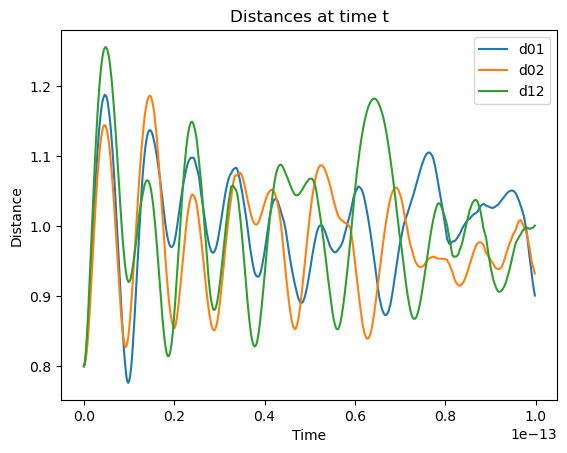

In [4]:
from matplotlib import pyplot as plt
(distance01,distance02,distance12,times) = main()

np_distance01 = np.array(distance01)
np_distance02 = np.array(distance02)
np_distance12 = np.array(distance12)

plt.plot(times,np_distance01[:-1],label = 'd01')
plt.plot(times,np_distance02[:-1],label = 'd02')
plt.plot(times,np_distance12[:-1],label = 'd12')
plt.title('Distances at time t')
plt.xlabel('Time')
plt.ylabel('Distance')
plt.legend()
plt.show()